# Benfordsches Gesetz: S&P500 Case Study 

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import collections
from matplotlib.pyplot import plot, draw, show

## 1. Download S&P500 closing prices from yahoo finance

In [2]:
# Read and print the stock tickers that make up the S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
print(tickers)

    Symbol       Security SEC filings             GICS Sector  \
0      MMM             3M     reports             Industrials   
1      AOS    A. O. Smith     reports             Industrials   
2      ABT         Abbott     reports             Health Care   
3     ABBV         AbbVie     reports             Health Care   
4     ABMD        Abiomed     reports             Health Care   
..     ...            ...         ...                     ...   
499    YUM    Yum! Brands     reports  Consumer Discretionary   
500   ZBRA          Zebra     reports  Information Technology   
501    ZBH  Zimmer Biomet     reports             Health Care   
502   ZION  Zions Bancorp     reports              Financials   
503    ZTS         Zoetis     reports             Health Care   

                      GICS Sub-Industry    Headquarters Location  \
0              Industrial Conglomerates    Saint Paul, Minnesota   
1                     Building Products     Milwaukee, Wisconsin   
2              

In [3]:
# Get the data for this tickers from yahoo finance for the time range from January 1st 2020 until March 31st 2022
df = yf.download(tickers.Symbol.to_list(),'2020-1-1','2022-03-31', auto_adjust=True)['Close']
print(df.head())

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
                    A        AAL         AAP       AAPL       ABBV        ABC  \
Date                                                                            
2019-12-31  84.168236  28.574404  155.357330  72.139954  79.233513  81.757469   
2020-01-02  84.799675  28.982893  154.629822  73.785927  80.137360  81.815147   
2020-01-03  83.438141  27.548195  154.639526  73.068558  79.376686  80.786209   
2020-01-06  83.684799  27.219410  152.098099  73.650795  80.003105  81.969002   
2020-01-07  83.941315  27.119778  150.293854  73.304413  79.546715  81.382416   

                  ABMD        ABT         ACN        ADBE  ...        WYNN  \
Date                                                       ...               
2019-12-31  170.589996  83.581085  203.577225  329.809998  ...  137.7

## 2. Data preparation

In [4]:
#we know we had two failed downloads. we drop those columns entirely
df = df.drop(['BF.B', 'BRK.B'], axis = 1) 

In [5]:
#by using isnull.sum() we check if there are tickers (columns) with missing values
for i in df.columns:
    if df[i].isnull().sum() > 0:
        print(i, df[i].isnull().sum())

CARR 54
CEG 517
OGN 345
OTIS 54


In [6]:
#we plot the respective tickers to see how much of the data is missing
df[['CARR', 'OTIS', 'CEG', 'OGN']].plot.line()

<AxesSubplot:xlabel='Date'>

We can see, that for CARR and OTIS the first three months from Januar until April are missing. CEG and OGN are missing even more of the data. We will drop those four tickers from our dataframe

In [7]:
#drop the tickers
df = df.drop(['CARR', 'OTIS', 'CEG', 'OGN'], axis = 1)

In [8]:
#create new, clean dataframe
dfclean = df

In [9]:
#last check to see if there are any missing values
dfclean.isnull().sum().sum()

0

In [10]:
#from the closing prices we create a dataframe with percentage change values from the previous closing day
data_pct = dfclean.pct_change()
data_pct.head()

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2019-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-02  0.007502  0.014296 -0.004683  0.022816  0.011407  0.000705   
2020-01-03 -0.016056 -0.049502  0.000063 -0.009722 -0.009492 -0.012576   
2020-01-06  0.002956 -0.011935 -0.016435  0.007968  0.007892  0.014641   
2020-01-07  0.003065 -0.003660 -0.011862 -0.004703 -0.005705 -0.007156   

                ABMD       ABT       ACN      ADBE  ...      WYNN       XEL  \
Date                                                ...                       
2019-12-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-01-02 -0.010434  0.001036 -0.001995  0.014008  ...  0.034061 -0.017483   
2020-01-03 -0.011788 -0.012191 -0.001665 -0.007834  ... -0.014833  0.004809   
2020-01-06  0.073253  0.005239 -0.006530  0.005726  ... -0.001979 -0.001436   
2020-01-07  0.007317 -0.005559 -0.021590 -0.000959  ...  0.004745 -0.002077   

                 XOM      XRAY       XYL       YUM       ZBH      ZBRA  \
Date                                                                     
2019-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
2020-01-02  0.016050  0.006008  0.013453  0.014296 -0.003207  0.014485   
2020-01-03 -0.008039 -0.011066  0.005886 -0.003132 -0.002614 -0.011924   
2020-01-06  0.007678  0.005506 -0.006474 -0.000589 -0.005779  0.007655   
2020-01-07 -0.008184  0.005299 -0.003759  0.001768 -0.000879 -0.005969   

                ZION       ZTS  
Date                            
2019-12-31       NaN       NaN  
2020-01-02  0.010015  0.013525  
2020-01-03 -0.014111  0.000149  
2020-01-06 -0.012186 -0.007677  
2020-01-07 -0.006070  0.003380  

[5 rows x 498 columns]

In [11]:
#checking for missing values
data_pct.isna().sum().sum()

498

In [12]:
#drop rows with missing values, then check again for missing values. The values that have been dropped were the first row (first day)
data_pct = data_pct.dropna()
data_pct.isna().sum().sum()

0

In [13]:
#create new dataframe with absolute values (for easier handling)
data_pct_abs = data_pct.abs()
data_pct_abs.head()

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2020-01-02  0.007502  0.014296  0.004683  0.022816  0.011407  0.000705   
2020-01-03  0.016056  0.049502  0.000063  0.009722  0.009492  0.012576   
2020-01-06  0.002956  0.011935  0.016435  0.007968  0.007892  0.014641   
2020-01-07  0.003065  0.003660  0.011862  0.004703  0.005705  0.007156   
2020-01-08  0.009873  0.022777  0.011488  0.016086  0.007087  0.009689   

                ABMD       ABT       ACN      ADBE  ...      WYNN       XEL  \
Date                                                ...                       
2020-01-02  0.010434  0.001036  0.001995  0.014008  ...  0.034061  0.017483   
2020-01-03  0.011788  0.012191  0.001665  0.007834  ...  0.014833  0.004809   
2020-01-06  0.073253  0.005239  0.006530  0.005726  ...  0.001979  0.001436   
2020-01-07  0.007317  0.005559  0.021590  0.000959  ...  0.004745  0.002077   
2020-01-08  0.009204  0.004076  0.001962  0.013438  ...  0.006274  0.000961   

                 XOM      XRAY       XYL       YUM       ZBH      ZBRA  \
Date                                                                     
2020-01-02  0.016050  0.006008  0.013453  0.014296  0.003207  0.014485   
2020-01-03  0.008039  0.011066  0.005886  0.003132  0.002614  0.011924   
2020-01-06  0.007678  0.005506  0.006474  0.000589  0.005779  0.007655   
2020-01-07  0.008184  0.005299  0.003759  0.001768  0.000879  0.005969   
2020-01-08  0.015080  0.010543  0.003396  0.001765  0.011974  0.034429   

                ZION       ZTS  
Date                            
2020-01-02  0.010015  0.013525  
2020-01-03  0.014111  0.000149  
2020-01-06  0.012186  0.007677  
2020-01-07  0.006070  0.003380  
2020-01-08  0.009850  0.002171  

[5 rows x 498 columns]

we multiply the absolute change values with a constant. Because there are very small values, we multiply with 1'000'000 to make sure there are no leading zeros anymore

In [14]:
#multiply with 1mio
data_multiplied = data_pct_abs * 1000000
data_multiplied.head()

A           AAL           AAP          AAPL  \
Date                                                                 
2020-01-02   7502.108166  14295.634327   4682.807972  22816.388466   
2020-01-03  16055.888408  49501.549253     62.760144   9722.302213   
2020-01-06   2956.181941  11934.899691  16434.527912   7968.369182   
2020-01-07   3065.258033   3660.338832  11862.377044   4703.033296   
2020-01-08   9873.067187  22777.389631  11488.317665  16086.125163   

                    ABBV           ABC          ABMD           ABT  \
Date                                                                 
2020-01-02  11407.379376    705.479551  10434.367885   1036.134636   
2020-01-03   9492.121110  12576.378900  11788.343482  12190.863969   
2020-01-06   7891.726125  14641.021985  73252.520234   5239.181006   
2020-01-07   5704.658337   7156.193023   7316.872579   5559.272165   
2020-01-08   7087.237745   9689.174681   9204.344918   4076.270265   

                     ACN          ADBE  ...          WYNN           XEL  \
Date                                    ...                               
2020-01-02   1994.882637  14008.050548  ...  34060.663140  17483.048291   
2020-01-03   1665.337091   7834.210970  ...  14832.862156   4809.054301   
2020-01-06   6530.052852   5726.150238  ...   1979.176931   1435.753197   
2020-01-07  21590.036987    958.846947  ...   4745.298865   2076.912327   
2020-01-08   1961.546719  13437.656414  ...   6273.827028    960.604882   

                     XOM          XRAY           XYL           YUM  \
Date                                                                 
2020-01-02  16050.288061   6008.191412  13453.295370  14295.569142   
2020-01-03   8039.231880  11066.200848   5885.989138   3131.898209   
2020-01-06   7678.002115   5506.136495   6473.979401    589.134332   
2020-01-07   8184.056345   5299.404151   3759.420259   1768.288776   
2020-01-08  15080.328104  10542.937017   3396.196906   1765.245349   

                     ZBH          ZBRA          ZION           ZTS  
Date                                                                
2020-01-02   3206.820016  14484.858173  10015.490270  13524.792821  
2020-01-03   2613.716500  11924.159454  14111.425440    149.124270  
2020-01-06   5779.244522   7654.841110  12185.679121   7677.369969  
2020-01-07    878.599614   5968.793793   6070.078184   3380.169586  
2020-01-08  11973.879332  34428.985024   9850.125511   2171.018943  

[5 rows x 498 columns]

In [15]:
#checking if there are values below 1 (to see if there are leading 0s)
for i in data_multiplied.columns:
    if data_multiplied[i].min() < 1:
        print(i, data_multiplied[i].min())

A 0.0
AAL 0.0
AAPL 0.0
ABBV 0.0
ABC 0.0
ABT 0.0
ADI 0.0
ADM 0.0
ADP 0.0
ADSK 0.0
AEE 0.0
AEP 0.0
AES 0.0
AFL 0.0
AIG 0.0
AJG 0.0
AKAM 0.0
ALB 0.0
ALK 0.0
ALL 0.0
AMAT 0.0
AMCR 0.0
AMD 0.0
AME 0.0
AMT 0.0
ANSS 0.0
ANTM 0.0
AON 0.0
AOS 0.0
APA 0.0
APH 0.0
ARE 0.0
ATO 0.0
ATVI 0.0
AVB 0.0
AVY 0.0
BA 0.0
BAC 0.0
BALL 0.0
BAX 0.0
BBWI 0.0
BBY 0.0
BDX 0.0
BEN 0.0
BIIB 0.0
BK 0.0
BKR 0.0
BLK 0.0
BMY 0.0
BR 0.0
BRO 0.0
BSX 0.0
BWA 0.0
C 0.0
CAG 0.0
CAH 0.0
CB 0.0
CBOE 0.0
CBRE 0.0
CCI 0.0
CCL 0.0
CDNS 0.0
CDW 0.0
CE 0.0
CERN 0.0
CFG 0.0
CHD 0.0
CHRW 0.0
CI 0.0
CINF 0.0
CL 0.0
CMA 0.0
CMCSA 0.0
CME 0.0
CMI 0.0
CMS 0.0
CNC 0.0
CNP 0.0
COF 0.0
COP 0.0
CPB 0.0
CPRT 0.0
CPT 0.0
CSCO 0.0
CSX 0.0
CTRA 0.0
CTSH 0.0
CTVA 0.0
CTXS 0.0
CVS 0.0
CZR 0.0
D 0.0
DAL 0.0
DD 0.0
DE 0.0
DFS 0.0
DG 0.0
DGX 0.0
DHI 0.0
DHR 0.0
DISH 0.0
DLR 0.0
DLTR 0.0
DOV 0.0
DOW 0.0
DPZ 0.0
DRE 0.0
DRI 0.0
DTE 0.0
DUK 0.0
DVA 0.0
DXC 0.0
EA 0.0
EBAY 0.0
ECL 0.0
ED 0.0
EFX 0.0
EIX 0.0
EL 0.0
EMR 0.0
EOG 0.0
EPAM 0.0
EQR 0.0
ES 0.

There are still zeros, because there are days with no change in closing price. We will deal with those zeros in the code below

## 3. Data analysis

### 3.1. S&P500 overall analysis

In [16]:
#creating a list out of all the values in the dataframe. This will create a list with n sublist
hcp_pct = data_pct_abs.values.tolist()

#turning list of lists into one flat list

flat_hcp_pct = []
for sublist in hcp_pct:
    for item in sublist:
        flat_hcp_pct.append(item)

Text(0.5, 0, 'absolute values of percentage change of stock prices')

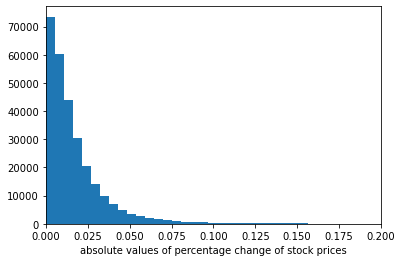

In [17]:
#plotting the values
plt.hist(flat_hcp_pct, 100)
plt.xlim(xmin=0, xmax = 0.2)
plt.xlabel('absolute values of percentage change of stock prices')

In [18]:
#creating a list out of all the values in the dataframe. This will create a list with n sublist (n = number of days)
hcp = data_multiplied.values.tolist()

#turning list of lists into one flat list

flat_hcp = []
for sublist in hcp:
    for item in sublist:
        flat_hcp.append(item)
        
        
#slicing every item in the list to get the first significant digit (fsd)
fsd = []
for i in flat_hcp:
    fsd.append(int(str(i)[:1]))
    
#there are 0s in the list. This is because there are closing prices that havent changed from one day to another. we will drop the 0s from the list
fsd = [x for x in fsd if x != 0]

unique_values_overall = set(fsd)
print(unique_values_overall)

#creating a dictionary with key = digit and value = frequency of that number
freq_overall = {} 
for item in fsd: 
    if (item in freq_overall): 
        freq_overall[item] += 1
    else: 
        freq_overall[item] = 1
        
#for easier use, we sort the dict by key
freq_overall_ord = collections.OrderedDict(sorted(freq_overall.items()))
freq_overall_ord

#calculate benford probability of the keys (numbers 1 to 9)
benf_prob_overall = [round(np.log10(1 + 1/i), 3) for i in freq_overall_ord.keys()]
benf_prob_overall

#calculate probability of fsd in dataset
digit_prob_overall = [round(i / sum(freq_overall_ord.values()),3) for i in freq_overall_ord.values() ]
digit_prob_overall

#create dataframe from dict and benf_prob and digit_prob
df_all = pd.DataFrame(list(freq_overall_ord.items()),columns = ['digit_overall','count_overall']) 
df_all['benf_prob_overall'] = benf_prob_overall
df_all['digit_prob_overall'] = digit_prob_overall
df_all['count_expected_overall'] = df_all['count_overall'].sum() * df_all['benf_prob_overall']
df_all


{1, 2, 3, 4, 5, 6, 7, 8, 9}


digit_overall  count_overall  benf_prob_overall  digit_prob_overall  \
0              1          92139              0.301               0.328   
1              2          52417              0.176               0.187   
2              3          33463              0.125               0.119   
3              4          24299              0.097               0.087   
4              5          19669              0.079               0.070   
5              6          16854              0.067               0.060   
6              7          15211              0.058               0.054   
7              8          13980              0.051               0.050   
8              9          12853              0.046               0.046   

   count_expected_overall  
0               84546.385  
1               49435.760  
2               35110.625  
3               27245.845  
4               22189.915  
5               18819.295  
6               16291.330  
7               14325.135  
8               12920.710

In [19]:
#plotting the results
df_all.plot.bar(x= 'digit_overall', y=['benf_prob_overall', 'digit_prob_overall'], xlabel = 'digit', ylabel = 'Probability', rot = 0, legend = True)

<AxesSubplot:xlabel='digit', ylabel='Probability'>

In [20]:
#calculating the chi-square value
chi_sq_overall = np.sum(((df_all['count_overall'] - df_all['count_expected_overall']) ** 2)/df_all['count_expected_overall'])
print('Goodness of fit overall is ', chi_sq_overall)

Goodness of fit overall is  1829.611671083573


### 3.2. individual stock analysis

In [21]:
#creating a dictionary from df data_multiplied
dic = data_multiplied.to_dict(orient='list')

running the below code can take a few minutues (2min, depending on pc performance), because it calculates chi-square testvalues for each of the 498 stocks and plots the results 

A {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
A {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 179), (2, 95), (3, 70), (4, 46), (5, 45), (6, 28), (7, 38), (8, 34), (9, 29)])
   digit  count  benf_prob  A prob  count_expected
0      1    179      0.301   0.317         169.764
1      2     95      0.176   0.168          99.264
2      3     70      0.125   0.124          70.500
3      4     46      0.097   0.082          54.708
4      5     45      0.079   0.080          44.556
5      6     28      0.067   0.050          37.788
6      7     38      0.058   0.067          32.712
7      8     34      0.051   0.060          28.764
8      9     29      0.046   0.051          25.944


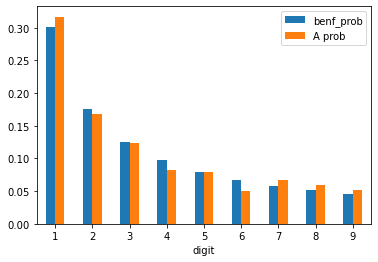

Goodness of fit for A is  6.782939858446429
{}
AAL {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AAL {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 149), (2, 108), (3, 73), (4, 65), (5, 53), (6, 32), (7, 33), (8, 25), (9, 23)])
   digit  count  benf_prob  AAL prob  count_expected
0      1    149      0.301     0.266         168.861
1      2    108      0.176     0.193          98.736
2      3     73      0.125     0.130          70.125
3      4     65      0.097     0.116          54.417
4      5     53      0.079     0.094          44.319
5      6     32      0.067     0.057          37.587
6      7     33      0.058     0.059          32.538
7      8     25      0.051     0.045          28.611
8      9     23      0.046     0.041          25.806


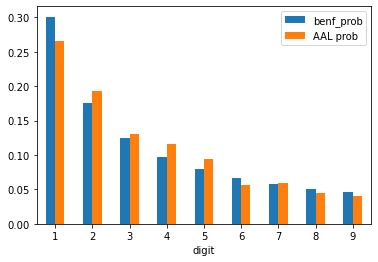

Goodness of fit for AAL is  8.679521446221232
{'A': 6.782939858446429}
AAP {1, 2, 3, 4, 5, 6, 7, 8, 9}
AAP {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 203), (2, 106), (3, 54), (4, 46), (5, 35), (6, 26), (7, 37), (8, 31), (9, 28)])
   digit  count  benf_prob  AAP prob  count_expected
0      1    203      0.301     0.359         170.366
1      2    106      0.176     0.187          99.616
2      3     54      0.125     0.095          70.750
3      4     46      0.097     0.081          54.902
4      5     35      0.079     0.062          44.714
5      6     26      0.067     0.046          37.922
6      7     37      0.058     0.065          32.828
7      8     31      0.051     0.055          28.866
8      9     28      0.046     0.049          26.036


Goodness of fit for AAP is  18.763717259981412
{'A': 6.782939858446429, 'AAL': 8.679521446221232}
AAPL {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AAPL {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 180), (2, 129), (3, 67), (4, 38), (5, 35), (6, 42), (7, 28), (8, 26), (9, 20)])
   digit  count  benf_prob  AAPL prob  count_expected
0      1    180      0.301      0.319         170.065
1      2    129      0.176      0.228          99.440
2      3     67      0.125      0.119          70.625
3      4     38      0.097      0.067          54.805
4      5     35      0.079      0.062          44.635
5      6     42      0.067      0.074          37.855
6      7     28      0.058      0.050          32.770
7      8     26      0.051      0.046          28.815
8      9     20      0.046      0.035          25.990


Goodness of fit for AAPL is  19.590111773374698
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412}
ABBV {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ABBV {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 188), (2, 80), (3, 63), (4, 38), (5, 46), (6, 39), (7, 43), (8, 33), (9, 33)])
   digit  count  benf_prob  ABBV prob  count_expected
0      1    188      0.301      0.334         169.463
1      2     80      0.176      0.142          99.088
2      3     63      0.125      0.112          70.375
3      4     38      0.097      0.067          54.611
4      5     46      0.079      0.082          44.477
5      6     39      0.067      0.069          37.721
6      7     43      0.058      0.076          32.654
7      8     33      0.051      0.059          28.713
8      9     33      0.046      0.059          25.898


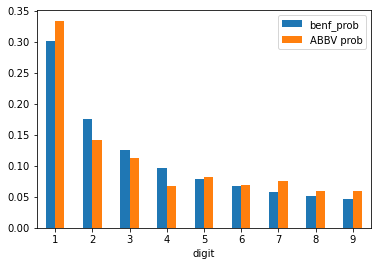

Goodness of fit for ABBV is  17.49134714165514
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698}
ABC {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ABC {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 190), (2, 110), (3, 60), (4, 41), (5, 35), (6, 32), (7, 28), (8, 39), (9, 29)])
   digit  count  benf_prob  ABC prob  count_expected
0      1    190      0.301     0.337         169.764
1      2    110      0.176     0.195          99.264
2      3     60      0.125     0.106          70.500
3      4     41      0.097     0.073          54.708
4      5     35      0.079     0.062          44.556
5      6     32      0.067     0.057          37.788
6      7     28      0.058     0.050          32.712
7      8     39      0.051     0.069          28.764
8      9     29      0.046     0.051          25.944


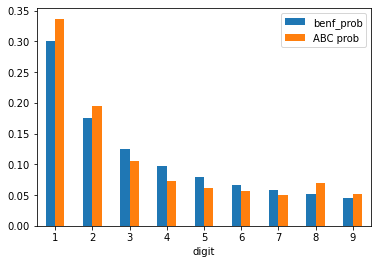

Goodness of fit for ABC is  16.189259600524398
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514}
ABMD {1, 2, 3, 4, 5, 6, 7, 8, 9}
ABMD {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 161), (2, 125), (3, 77), (4, 41), (5, 39), (6, 39), (7, 22), (8, 37), (9, 25)])
   digit  count  benf_prob  ABMD prob  count_expected
0      1    161      0.301      0.284         170.366
1      2    125      0.176      0.221          99.616
2      3     77      0.125      0.136          70.750
3      4     41      0.097      0.072          54.902
4      5     39      0.079      0.069          44.714
5      6     39      0.067      0.069          37.922
6      7     22      0.058      0.039          32.828
7      8     37      0.051      0.065          28.866
8      9     25      0.046      0.044          26.036


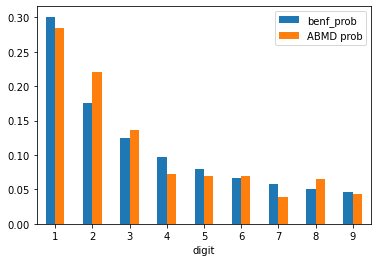

Goodness of fit for ABMD is  17.721136969993772
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398}
ABT {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ABT {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 194), (2, 98), (3, 64), (4, 42), (5, 42), (6, 27), (7, 33), (8, 33), (9, 32)])
   digit  count  benf_prob  ABT prob  count_expected
0      1    194      0.301     0.343         170.065
1      2     98      0.176     0.173          99.440
2      3     64      0.125     0.113          70.625
3      4     42      0.097     0.074          54.805
4      5     42      0.079     0.074          44.635
5      6     27      0.067     0.048          37.855
6      7     33      0.058     0.058          32.770
7      8     33      0.051     0.058          28.815
8      9     32      0.046     0.057          25.990


Goodness of fit for ABT is  12.270225537378655
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772}
ACN {1, 2, 3, 4, 5, 6, 7, 8, 9}
ACN {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 190), (2, 88), (3, 68), (4, 41), (5, 37), (6, 37), (7, 40), (8, 33), (9, 32)])
   digit  count  benf_prob  ACN prob  count_expected
0      1    190      0.301     0.336         170.366
1      2     88      0.176     0.155          99.616
2      3     68      0.125     0.120          70.750
3      4     41      0.097     0.072          54.902
4      5     37      0.079     0.065          44.714
5      6     37      0.067     0.065          37.922
6      7     40      0.058     0.071          32.828
7      8     33      0.051     0.058          28.866
8      9     32      0.046     0.057          26.036


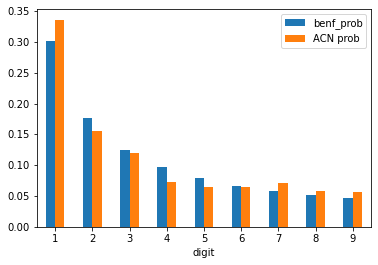

Goodness of fit for ACN is  12.12264860013799
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655}
ADBE {1, 2, 3, 4, 5, 6, 7, 8, 9}
ADBE {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 184), (2, 100), (3, 75), (4, 68), (5, 38), (6, 32), (7, 26), (8, 23), (9, 20)])
   digit  count  benf_prob  ADBE prob  count_expected
0      1    184      0.301      0.325         170.366
1      2    100      0.176      0.177          99.616
2      3     75      0.125      0.133          70.750
3      4     68      0.097      0.120          54.902
4      5     38      0.079      0.067          44.714
5      6     32      0.067      0.057          37.922
6      7     26      0.058      0.046          32.828
7      8     23      0.051      0.041          28.866
8      9     20      0.046      0.035          26.036


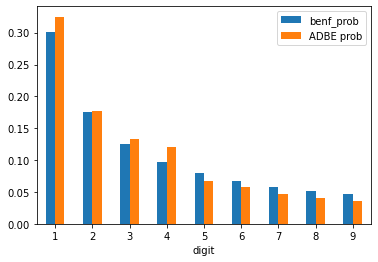

Goodness of fit for ADBE is  10.41718539947774
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799}
ADI {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ADI {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 185), (2, 99), (3, 79), (4, 51), (5, 37), (6, 30), (7, 28), (8, 23), (9, 33)])
   digit  count  benf_prob  ADI prob  count_expected
0      1    185      0.301     0.327         170.065
1      2     99      0.176     0.175          99.440
2      3     79      0.125     0.140          70.625
3      4     51      0.097     0.090          54.805
4      5     37      0.079     0.065          44.635
5      6     30      0.067     0.053          37.855
6      7     28      0.058     0.050          32.770
7      8     23      0.051     0.041          28.815
8      9     33      0.046     0.058          25.990


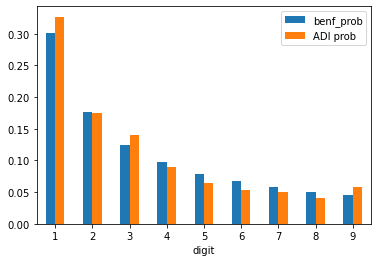

Goodness of fit for ADI is  9.26531878568213
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774}
ADM {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ADM {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 212), (2, 77), (3, 57), (4, 49), (5, 39), (6, 32), (7, 35), (8, 26), (9, 36)])
   digit  count  benf_prob  ADM prob  count_expected
0      1    212      0.301     0.377         169.463
1      2     77      0.176     0.137          99.088
2      3     57      0.125     0.101          70.375
3      4     49      0.097     0.087          54.611
4      5     39      0.079     0.069          44.477
5      6     32      0.067     0.057          37.721
6      7     35      0.058     0.062          32.654
7      8     26      0.051     0.046          28.713
8      9     36      0.046     0.064          2

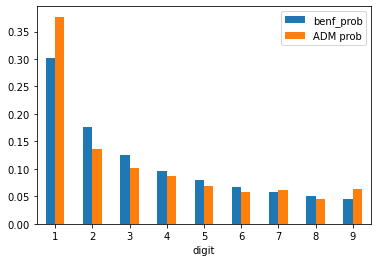

Goodness of fit for ADM is  24.626897412925548
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213}
ADP {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ADP {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 203), (2, 99), (3, 45), (4, 40), (5, 38), (6, 41), (7, 38), (8, 24), (9, 36)])
   digit  count  benf_prob  ADP prob  count_expected
0      1    203      0.301     0.360         169.764
1      2     99      0.176     0.176          99.264
2      3     45      0.125     0.080          70.500
3      4     40      0.097     0.071          54.708
4      5     38      0.079     0.067          44.556
5      6     41      0.067     0.073          37.788
6      7     38      0.058     0.067          32.712
7      8     24      0.051     0.043          28.764
8      9     36     

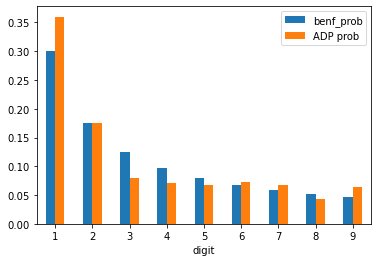

Goodness of fit for ADP is  26.46442867225178
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548}
ADSK {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ADSK {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 187), (2, 107), (3, 66), (4, 60), (5, 40), (6, 28), (7, 32), (8, 25), (9, 20)])
   digit  count  benf_prob  ADSK prob  count_expected
0      1    187      0.301      0.331         170.065
1      2    107      0.176      0.189          99.440
2      3     66      0.125      0.117          70.625
3      4     60      0.097      0.106          54.805
4      5     40      0.079      0.071          44.635
5      6     28      0.067      0.050          37.855
6      7     32      0.058      0.057          32.770
7      8     25      0.051      0.04

Goodness of fit for ADSK is  8.007082836242871
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178}
AEE {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AEE {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 198), (2, 76), (3, 60), (4, 44), (5, 41), (6, 41), (7, 34), (8, 34), (9, 33)])
   digit  count  benf_prob  AEE prob  count_expected
0      1    198      0.301     0.353         168.861
1      2     76      0.176     0.135          98.736
2      3     60      0.125     0.107          70.125
3      4     44      0.097     0.078          54.417
4      5     41      0.079     0.073          44.319
5      6     41      0.067     0.073          37.587
6      7     34      0.058     0.061          32.538
7      8     34     

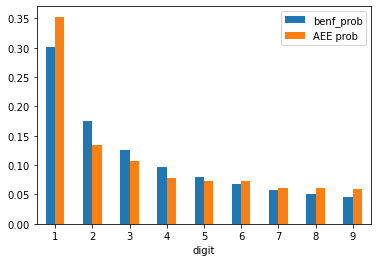

Goodness of fit for AEE is  17.364419474558353
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871}
AEP {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AEP {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 183), (2, 89), (3, 62), (4, 60), (5, 40), (6, 30), (7, 37), (8, 37), (9, 25)])
   digit  count  benf_prob  AEP prob  count_expected
0      1    183      0.301     0.325         169.463
1      2     89      0.176     0.158          99.088
2      3     62      0.125     0.110          70.375
3      4     60      0.097     0.107          54.611
4      5     40      0.079     0.071          44.477
5      6     30      0.067     0.053          37.721
6      7     37      0.058     0.066          

Goodness of fit for AEP is  8.669205191869949
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353}
AES {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AES {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 170), (2, 97), (3, 74), (4, 51), (5, 40), (6, 36), (7, 27), (8, 33), (9, 29)])
   digit  count  benf_prob  AES prob  count_expected
0      1    170      0.301     0.305         167.657
1      2     97      0.176     0.174          98.032
2      3     74      0.125     0.133          69.625
3      4     51      0.097     0.092          54.029
4      5     40      0.079     0.072          44.003
5      6     36      0.067     0.065          37.319
6      7     27     

Goodness of fit for AES is  2.9585508570530807
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949}
AFL {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AFL {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 207), (2, 94), (3, 60), (4, 46), (5, 34), (6, 34), (7, 30), (8, 35), (9, 21)])
   digit  count  benf_prob  AFL prob  count_expected
0      1    207      0.301     0.369         168.861
1      2     94      0.176     0.168          98.736
2      3     60      0.125     0.107          70.125
3      4     46      0.097     0.082          54.417
4      5     34      0.079     0.061          44.319
5      6     34      0.067     0.061          

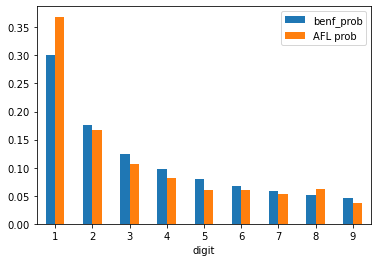

Goodness of fit for AFL is  16.869712391597695
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807}
AIG {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AIG {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 187), (2, 109), (3, 77), (4, 39), (5, 38), (6, 40), (7, 24), (8, 23), (9, 24)])
   digit  count  benf_prob  AIG prob  count_expected
0      1    187      0.301     0.333         168.861
1      2    109      0.176     0.194          98.736
2      3     77      0.125     0.137          70.125
3      4     39      0.097     0.070          54.417
4      5     38      0.079     0.068          44.319
5      6     40   

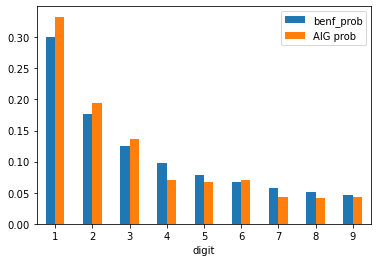

Goodness of fit for AIG is  12.580346851907237
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695}
AIZ {1, 2, 3, 4, 5, 6, 7, 8, 9}
AIZ {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 188), (2, 97), (3, 55), (4, 43), (5, 46), (6, 36), (7, 38), (8, 31), (9, 32)])
   digit  count  benf_prob  AIZ prob  count_expected
0      1    188      0.301     0.332         170.366
1      2     97      0.176     0.171          99.616
2      3     55      0.125     0.097          70.750
3      4     43      0.097     0.076          54.902
4      5     46      0.079     0.081          44

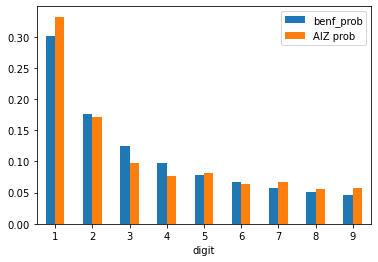

Goodness of fit for AIZ is  10.45346661847789
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237}
AJG {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AJG {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 187), (2, 85), (3, 67), (4, 41), (5, 45), (6, 40), (7, 32), (8, 42), (9, 26)])
   digit  count  benf_prob  AJG prob  count_expected
0      1    187      0.301     0.331         170.065
1      2     85      0.176     0.150          99.440
2      3     67      0.125     0.119          70.625
3      4     41      0.097     0.073          54.805
4      5     45    

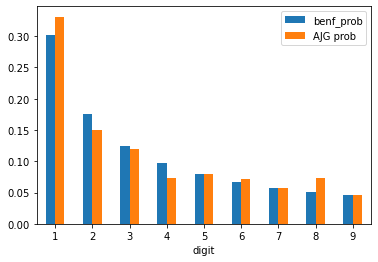

Goodness of fit for AJG is  13.622444768542229
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789}
AKAM {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AKAM {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 183), (2, 91), (3, 64), (4, 44), (5, 45), (6, 40), (7, 35), (8, 35), (9, 28)])
   digit  count  benf_prob  AKAM prob  count_expected
0      1    183      0.301      0.324         170.065
1      2     91      0.176      0.161          99.440
2      3     64      0.125      0.113          70.625
3      4     44      0.097      0.078  

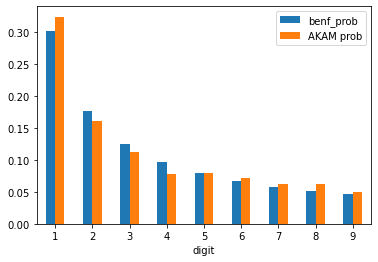

Goodness of fit for AKAM is  6.211185184723109
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229}
ALB {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ALB {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 165), (2, 120), (3, 88), (4, 47), (5, 52), (6, 32), (7, 19), (8, 23), (9, 19)])
   digit  count  benf_prob  ALB prob  count_expected
0      1    165      0.301     0.292         170.065
1      2    120      0.176     0.212          99.440
2      3     88      0.125     0.156          70.625
3      4     47  

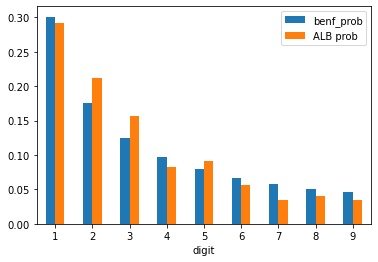

Goodness of fit for ALB is  20.74836443588689
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109}
ALGN {1, 2, 3, 4, 5, 6, 7, 8, 9}
ALGN {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 180), (2, 121), (3, 81), (4, 42), (5, 36), (6, 27), (7, 38), (8, 21), (9, 20)])
   digit  count  benf_prob  ALGN prob  count_expected
0      1    180      0.301      0.318         170.366
1      2    121      0.176      0.214          99.616
2      3     81      0.125      0.143     

Goodness of fit for ALGN is  18.853685602903383
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689}
ALK {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ALK {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 158), (2, 112), (3, 77), (4, 52), (5, 47), (6, 46), (7, 27), (8, 34), (9, 11)])
   digit  count  benf_prob  ALK prob  count_expected
0      1    158      0.301     0.280         169.764
1      2    112      0.176     0.199          99.264
2      3     77 

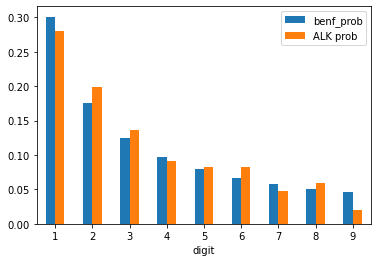

Goodness of fit for ALK is  15.659707170468598
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383}
ALL {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ALL {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 214), (2, 88), (3, 57), (4, 44), (5, 37), (6, 26), (7, 36), (8, 39), (9, 23)])
   digit  count  benf_prob  ALL prob  count_expected
0      1    214      0.301     0.379         169.764
1      2     88      0.176     0.156       

Goodness of fit for ALL is  26.751711789750896
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598}
ALLE {1, 2, 3, 4, 5, 6, 7, 8, 9}
ALLE {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 181), (2, 118), (3, 57), (4, 40), (5, 39), (6, 32), (7, 30), (8, 36), (9, 33)])
   digit  count  benf_prob  ALLE prob  count_expected
0      1    181      0.301      0.320         170.366
1      2    11

Goodness of fit for ALLE is  16.298019542593863
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896}
AMAT {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AMAT {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 153), (2, 122), (3, 87), (4, 63), (5, 43), (6, 30), (7, 28), (8, 19), (9, 20)])
   digit  count  benf_prob  AMAT prob  count_expected
0      1    153      0.301      0.271

Goodness of fit for AMAT is  18.960523449179107
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863}
AMCR {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AMCR {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 185), (2, 91), (3, 56), (4, 42), (5, 44), (6, 34), (7, 28), (8, 43), (9, 25)])
   digit  count  benf_prob  AMCR prob  count_expected
0      1  

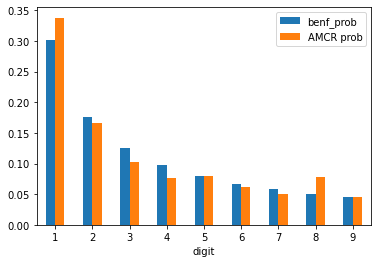

Goodness of fit for AMCR is  16.1390193975623
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107}
AMD {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AMD {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 135), (2, 122), (3, 88), (4, 47), (5, 52), (6, 38), (7, 35), (8, 26), (9, 22)])
   digit  count  benf_prob  AMD prob  c

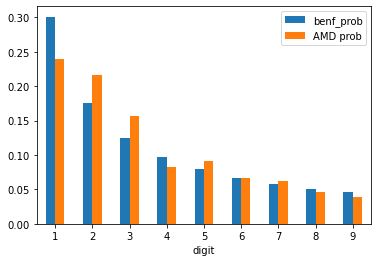

Goodness of fit for AMD is  19.989324080660257
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623}
AME {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AME {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 193), (2, 88), (3, 61), (4, 53), (5, 41), (6, 34), (7, 38), (8, 27), (9, 30)])
   digit  cou

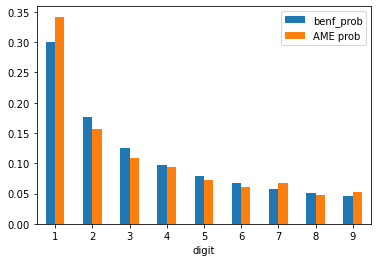

Goodness of fit for AME is  8.03662401738921
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257}
AMGN {1, 2, 3, 4, 5, 6, 7, 8, 9}
AMGN {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 197), (2, 73), (3, 58), (4, 51), (5, 41), (6, 44), (7, 39), (8, 36),

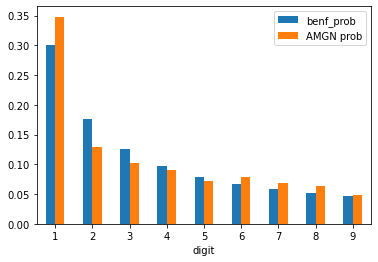

Goodness of fit for AMGN is  18.09210074640786
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921}
AMP {1, 2, 3, 4, 5, 6, 7, 8, 9}
AMP {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 175), (2, 115), (3, 68), (4, 43), (5, 36), 

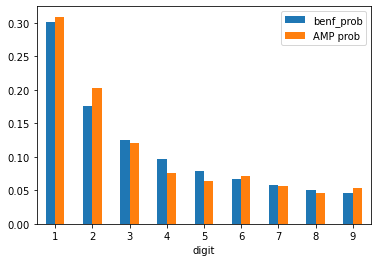

Goodness of fit for AMP is  8.045926620118642
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786}
AMT {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
AMT {1, 2, 3, 4, 5, 6, 7, 8, 9}
OrderedDict([(1, 189), (2, 105)

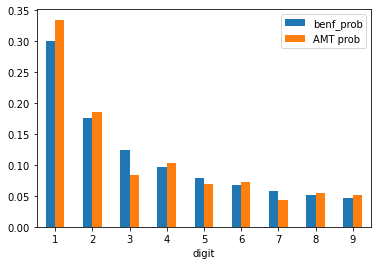

Goodness of fit for AMT is  13.860285896486326
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642}
AMZN {1, 2, 3, 4, 5, 6, 7, 8, 9}
AMZN {1, 2, 3, 4, 5, 6, 7, 8, 9}
Order

Goodness of fit for AMZN is  7.718906095737118
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326}
ANET {1, 2, 3, 4, 5, 6, 7, 8, 9}
ANET {1, 2,

Goodness of fit for ANET is  35.32437328387649
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118}
ANSS {0, 1, 2, 3,

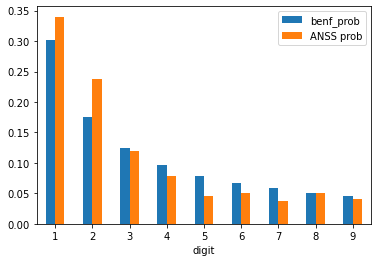

Goodness of fit for ANSS is  31.514069174201634
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

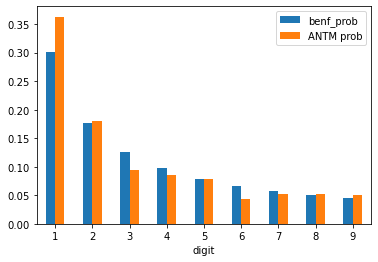

Goodness of fit for ANTM is  17.298441892297593
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

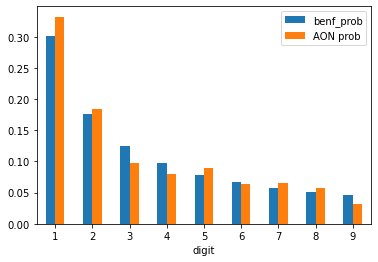

Goodness of fit for AON is  11.214760567698423
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

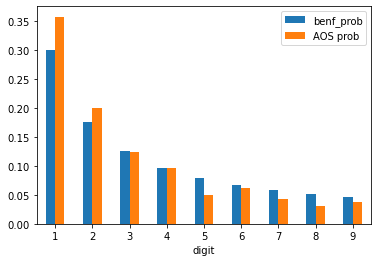

Goodness of fit for AOS is  22.4658585485593
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

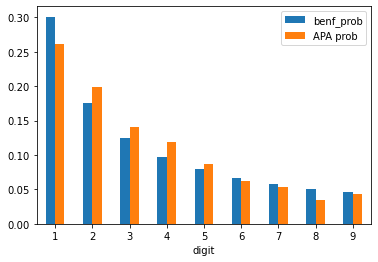

Goodness of fit for APA is  12.433436762826934
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

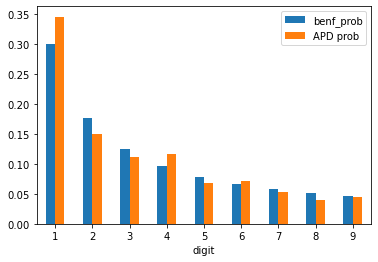

Goodness of fit for APD is  11.855857573487912
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

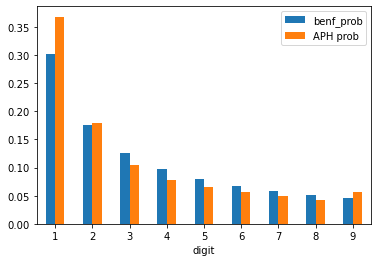

Goodness of fit for APH is  17.630325723217048
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

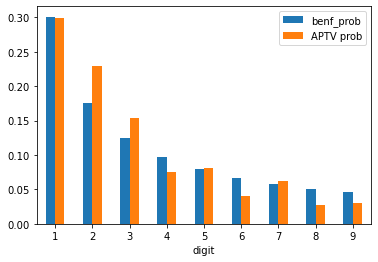

Goodness of fit for APTV is  30.513895478450458
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

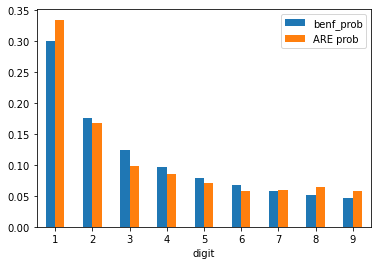

Goodness of fit for ARE is  11.545815392092628
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for ATO is  14.335740806275751
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

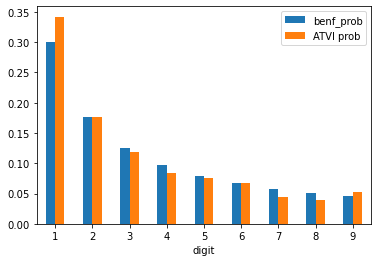

Goodness of fit for ATVI is  8.38627213941792
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for AVB is  30.807802556775513
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

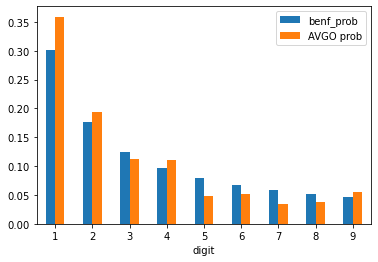

Goodness of fit for AVGO is  25.9161242835313
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

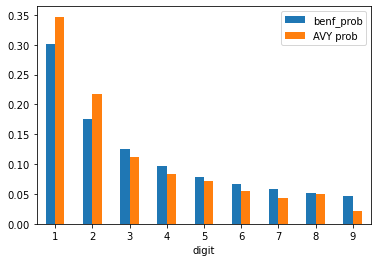

Goodness of fit for AVY is  22.435494257975567
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

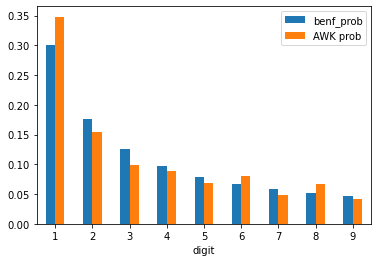

Goodness of fit for AWK is  15.241538520682768
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

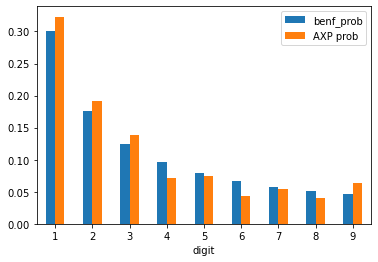

Goodness of fit for AXP is  16.10531547616598
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

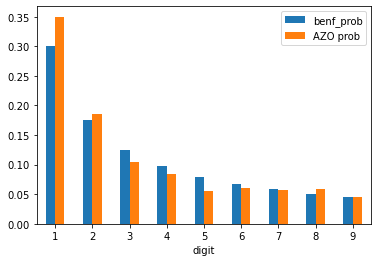

Goodness of fit for AZO is  12.817180246817058
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

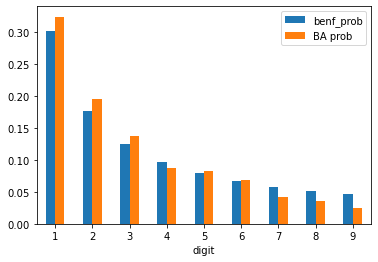

Goodness of fit for BA is  14.031665921345747
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

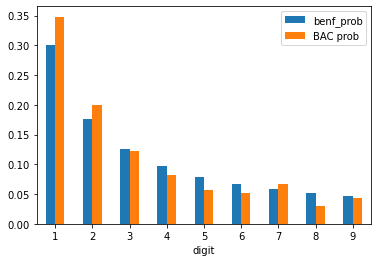

Goodness of fit for BAC is  18.531596594720085
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

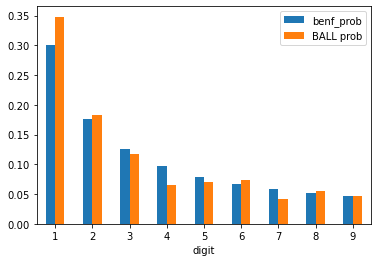

Goodness of fit for BALL is  14.03359504309834
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

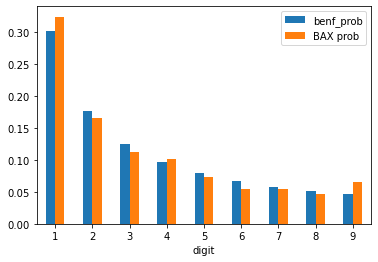

Goodness of fit for BAX is  8.555251023719954
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

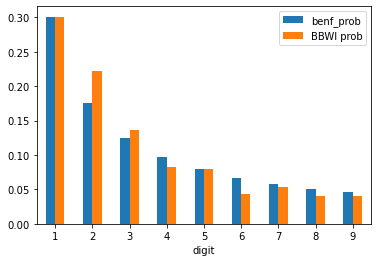

Goodness of fit for BBWI is  14.407283966037232
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

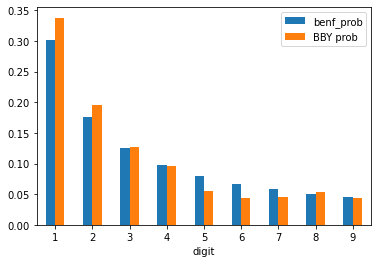

Goodness of fit for BBY is  13.975178701769657
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

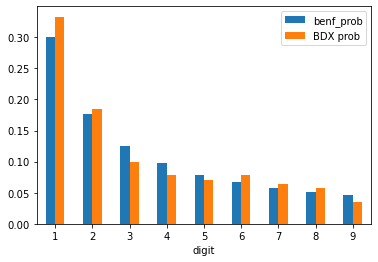

Goodness of fit for BDX is  11.044855102751592
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

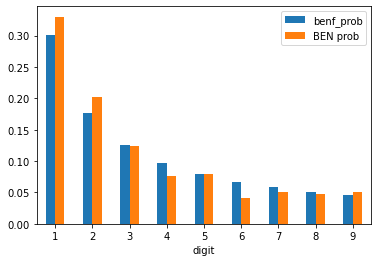

Goodness of fit for BEN is  12.990980328240507
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

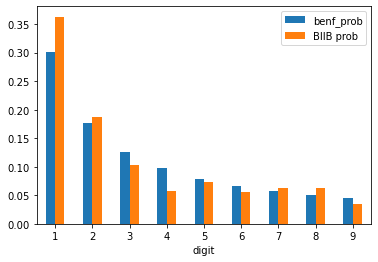

Goodness of fit for BIIB is  22.798231136847573
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for BIO is  19.762736143574937
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

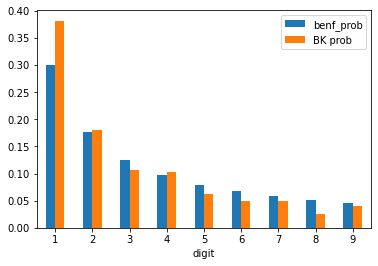

Goodness of fit for BK is  27.11310407042406
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

Goodness of fit for BKNG is  14.918004670160181
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for BKR is  9.094914474109146
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for BLK is  12.420766569742948
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

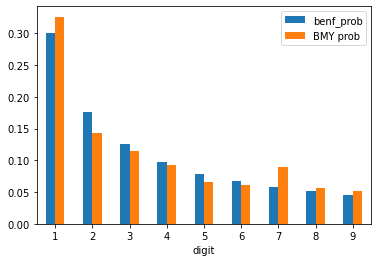

Goodness of fit for BMY is  17.100525574781173
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

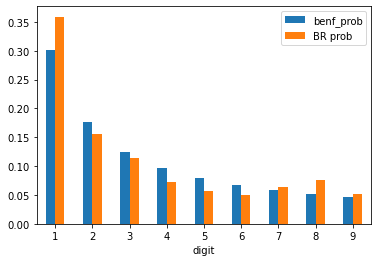

Goodness of fit for BR is  25.28634955177433
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

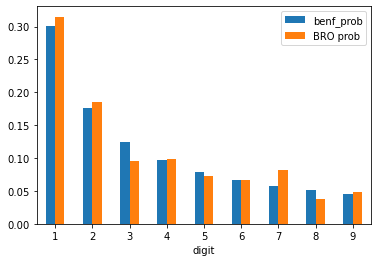

Goodness of fit for BRO is  12.270692718842325
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

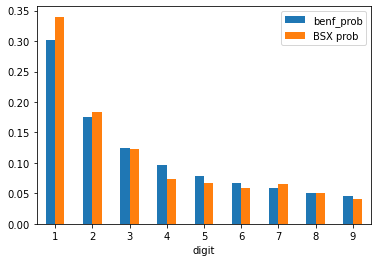

Goodness of fit for BSX is  9.075066921267016
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

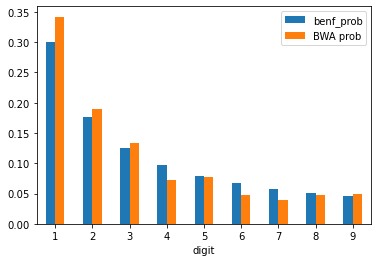

Goodness of fit for BWA is  14.370945848619902
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

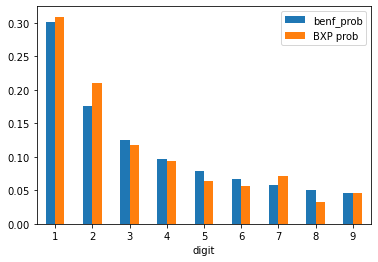

Goodness of fit for BXP is  12.442794758769743
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

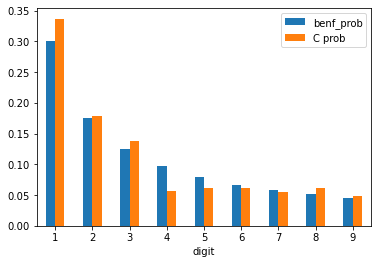

Goodness of fit for C is  16.405662715855147
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

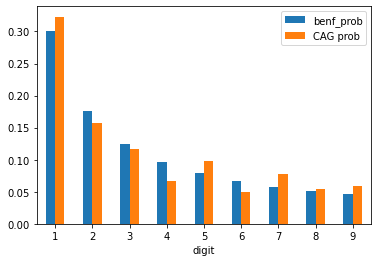

Goodness of fit for CAG is  18.47651359459372
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

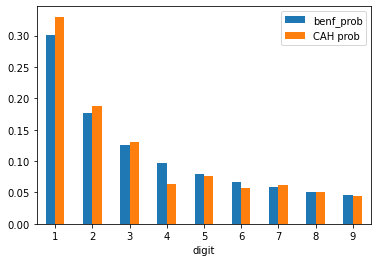

Goodness of fit for CAH is  9.541008615339834
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

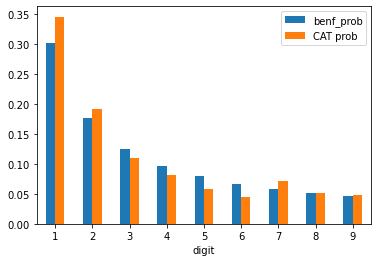

Goodness of fit for CAT is  16.335712082187456
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

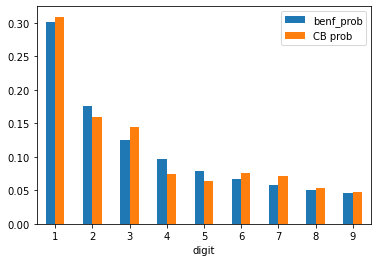

Goodness of fit for CB is  9.87975516765958
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

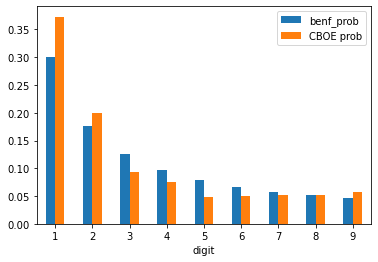

Goodness of fit for CBOE is  30.001234193433167
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

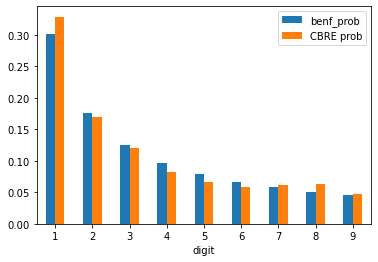

Goodness of fit for CBRE is  6.629935739662505
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

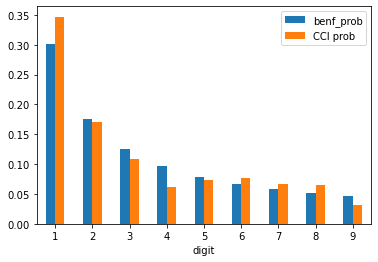

Goodness of fit for CCI is  19.154110615403205
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

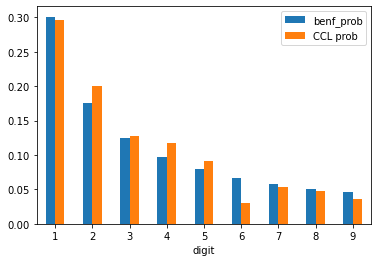

Goodness of fit for CCL is  18.223905871768658
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

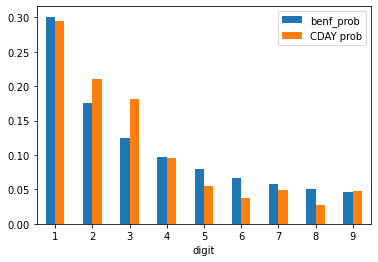

Goodness of fit for CDAY is  36.79132476383833
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

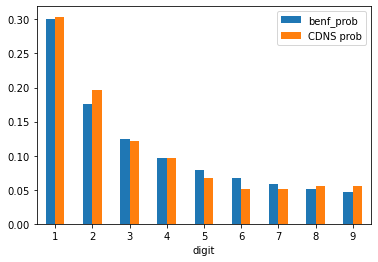

Goodness of fit for CDNS is  6.026769089489927
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

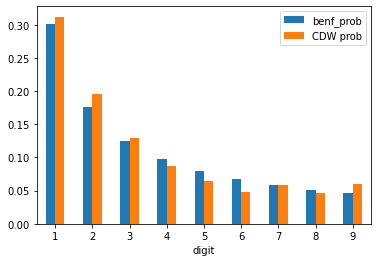

Goodness of fit for CDW is  9.566906810874167
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

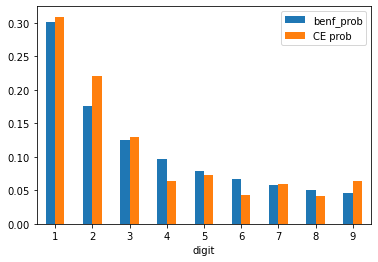

Goodness of fit for CE is  23.125884368724844
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

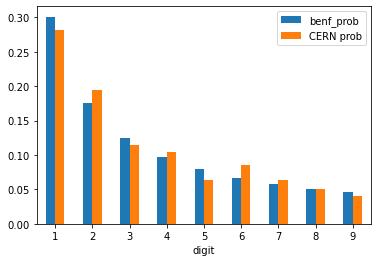

Goodness of fit for CERN is  7.841873202491663
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

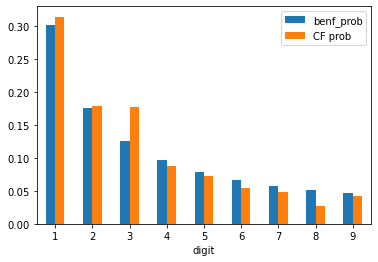

Goodness of fit for CF is  22.515012389367485
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

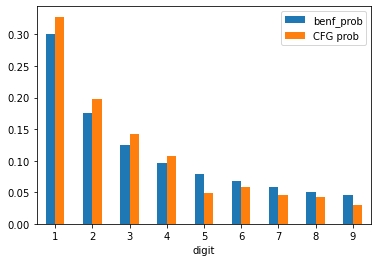

Goodness of fit for CFG is  17.532453365922773
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

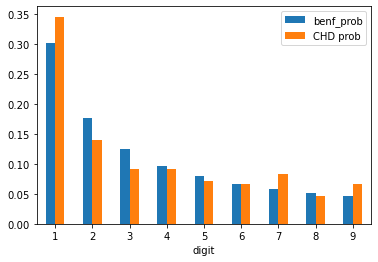

Goodness of fit for CHD is  24.969070867499
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

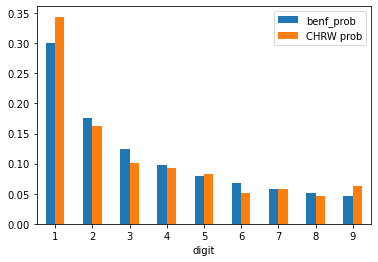

Goodness of fit for CHRW is  12.330701916335475
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

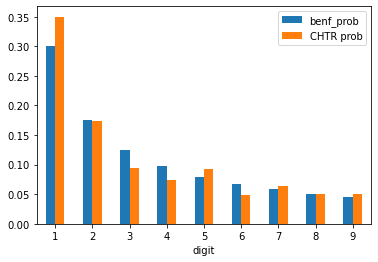

Goodness of fit for CHTR is  15.933867497244758
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

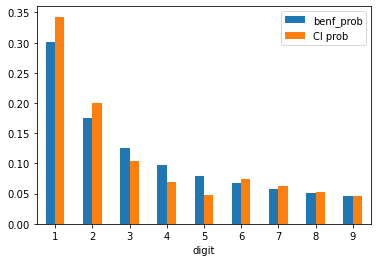

Goodness of fit for CI is  19.31097442142414
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

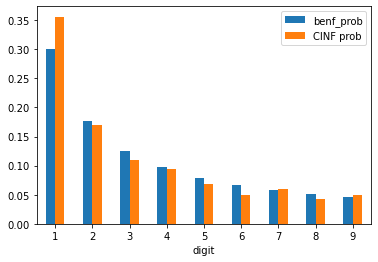

Goodness of fit for CINF is  11.142085128005338
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

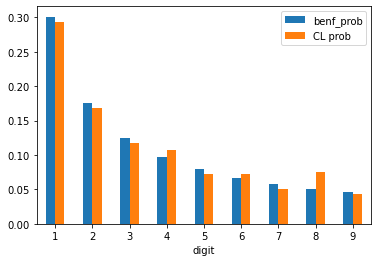

Goodness of fit for CL is  8.611325963488325
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

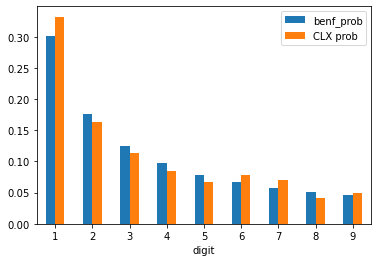

Goodness of fit for CLX is  8.436783614829976
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

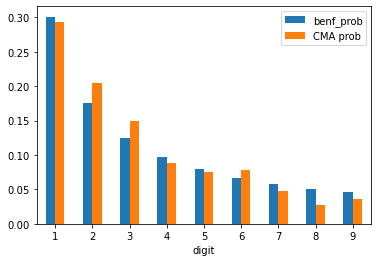

Goodness of fit for CMA is  15.780720682152902
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for CMCSA is  18.826705440435173
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243

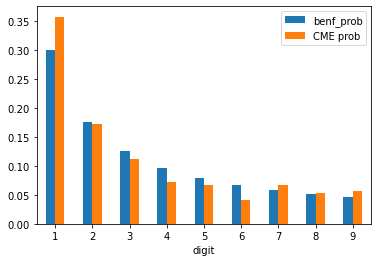

Goodness of fit for CME is  18.687720398017344
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

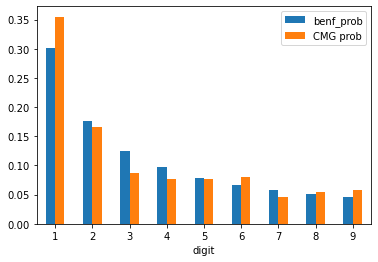

Goodness of fit for CMG is  20.31867145287309
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

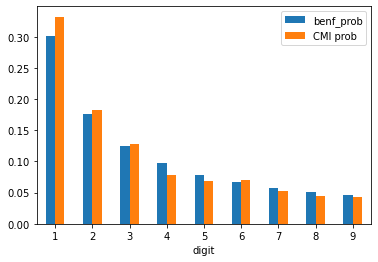

Goodness of fit for CMI is  5.703715876140318
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

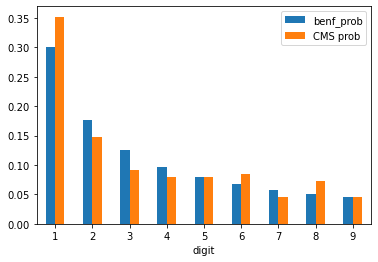

Goodness of fit for CMS is  23.57999674836222
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

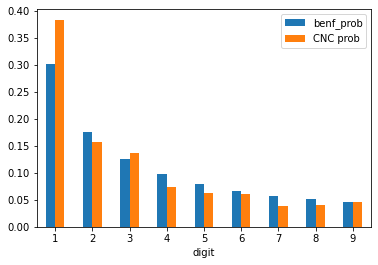

Goodness of fit for CNC is  24.822362737957278
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for CNP is  2.184802777740332
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

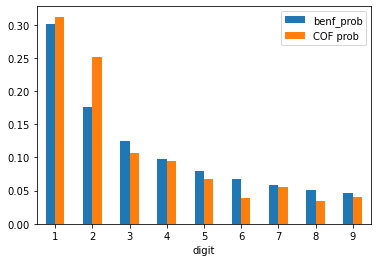

Goodness of fit for COF is  31.544330155258105
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

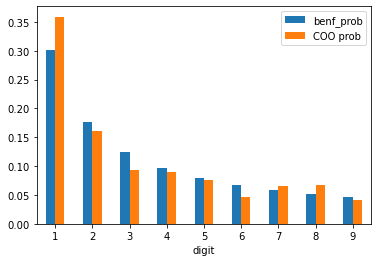

Goodness of fit for COO is  19.120273010514623
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for COP is  17.04420696079148
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for COST is  30.716296288754073
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

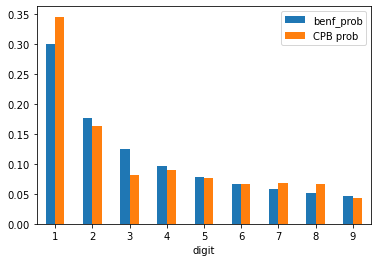

Goodness of fit for CPB is  16.83184248845896
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

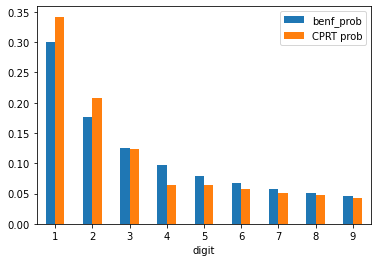

Goodness of fit for CPRT is  15.645514707747992
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

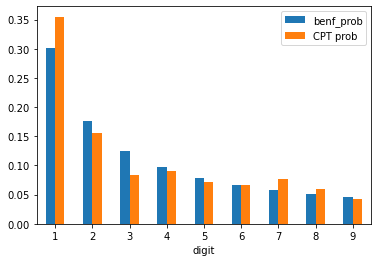

Goodness of fit for CPT is  19.835163012724877
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

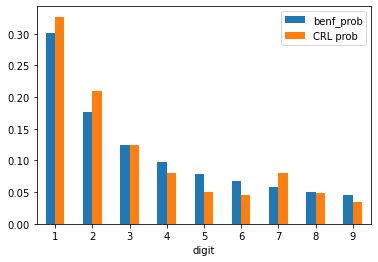

Goodness of fit for CRL is  22.285932678123366
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

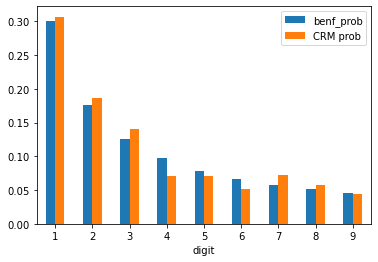

Goodness of fit for CRM is  10.634555302568195
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

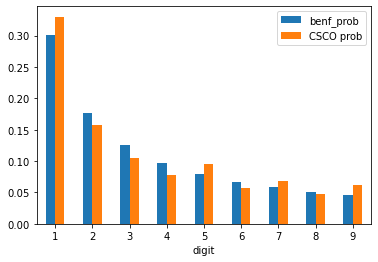

Goodness of fit for CSCO is  13.706826563668415
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

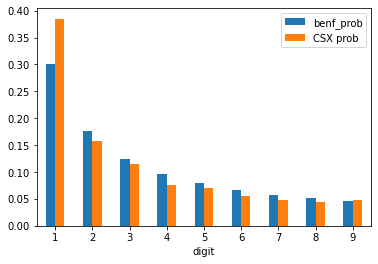

Goodness of fit for CSX is  20.56223740219358
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for CTAS is  31.06946270039466
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

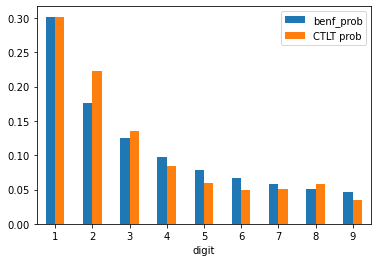

Goodness of fit for CTLT is  16.011129781322555
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for CTRA is  39.40838002790031
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

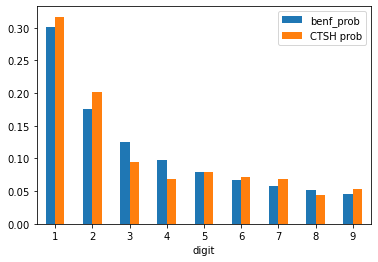

Goodness of fit for CTSH is  14.013461233839356
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for CTVA is  13.474977600346419
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

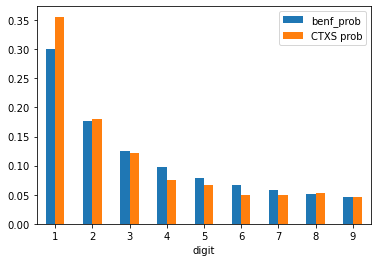

Goodness of fit for CTXS is  12.568158093079939
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

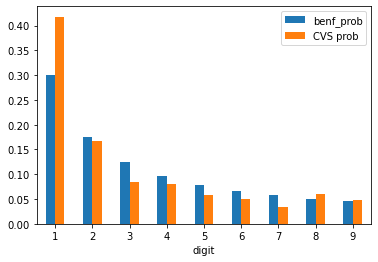

Goodness of fit for CVS is  47.30197218686348
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

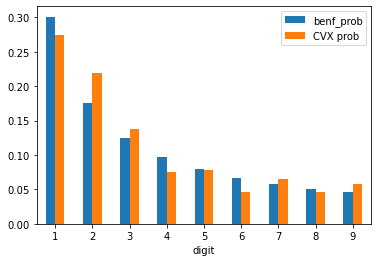

Goodness of fit for CVX is  17.11468624399722
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

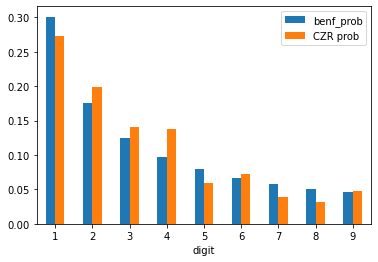

Goodness of fit for CZR is  24.888353983518112
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

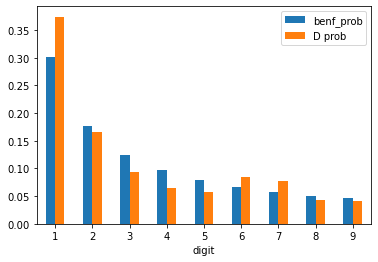

Goodness of fit for D is  31.580250295131115
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

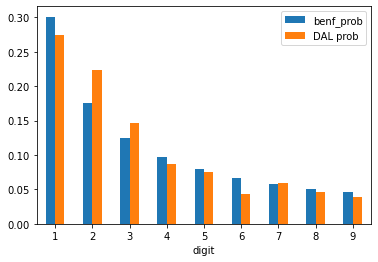

Goodness of fit for DAL is  16.622549903576505
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

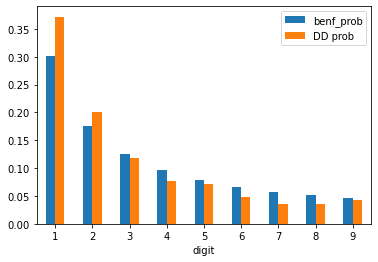

Goodness of fit for DD is  25.418102166805465
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

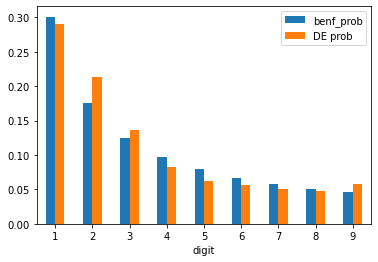

Goodness of fit for DE is  12.001981412171302
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

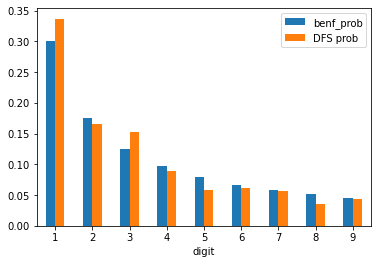

Goodness of fit for DFS is  12.675376844359196
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

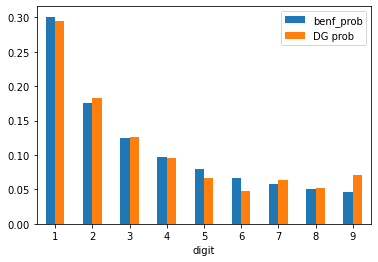

Goodness of fit for DG is  12.566218148763264
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for DGX is  9.923317958354673
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

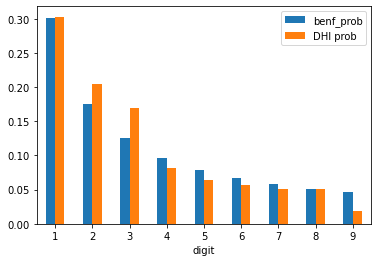

Goodness of fit for DHI is  24.628201925594833
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

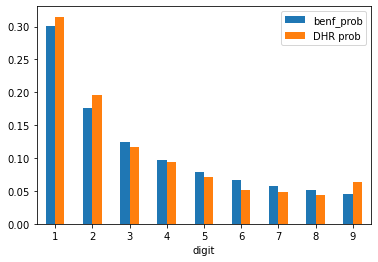

Goodness of fit for DHR is  10.005463824737493
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

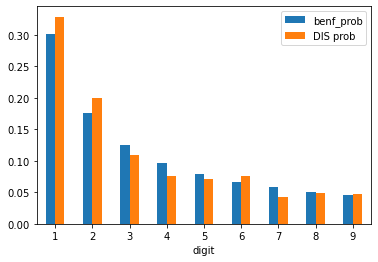

Goodness of fit for DIS is  10.507876646306649
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

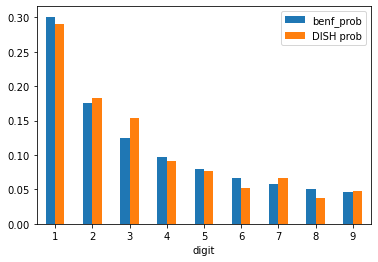

Goodness of fit for DISH is  8.919486393456268
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

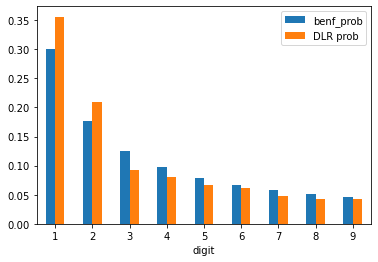

Goodness of fit for DLR is  18.592117013095194
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

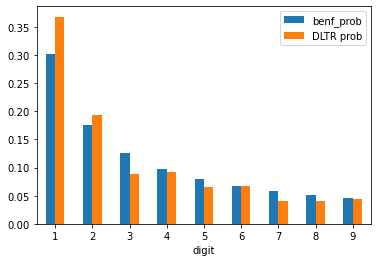

Goodness of fit for DLTR is  20.97829676746689
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

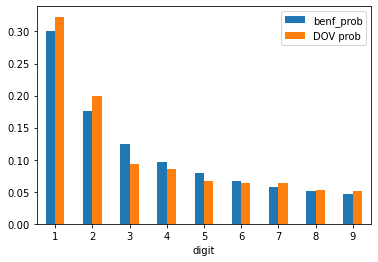

Goodness of fit for DOV is  9.47531191552862
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

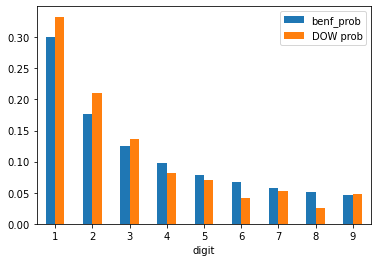

Goodness of fit for DOW is  21.439574294905537
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

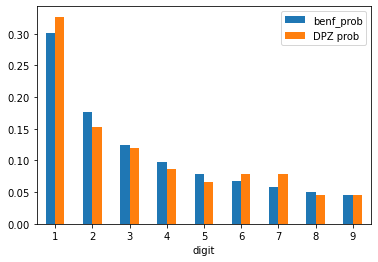

Goodness of fit for DPZ is  10.2152943153904
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

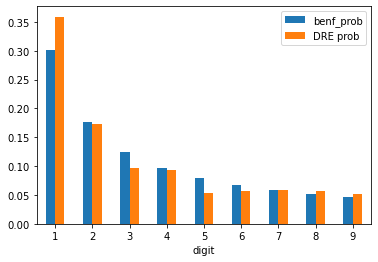

Goodness of fit for DRE is  16.507724632304683
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for DRI is  10.218773263159456
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

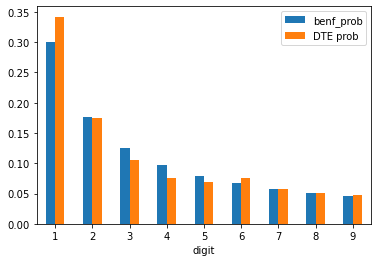

Goodness of fit for DTE is  8.738017933661565
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

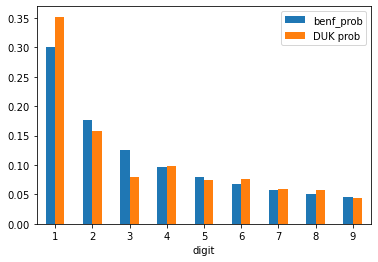

Goodness of fit for DUK is  16.324417817124992
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for DVA is  9.024909204515929
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

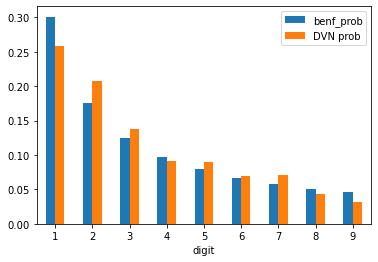

Goodness of fit for DVN is  12.89417630148699
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

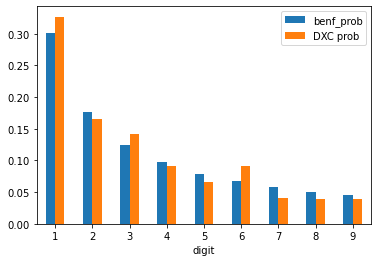

Goodness of fit for DXC is  14.118149325627098
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for DXCM is  19.33833470558451
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for EA is  27.299410207250986
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for EBAY is  13.571399265342224
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

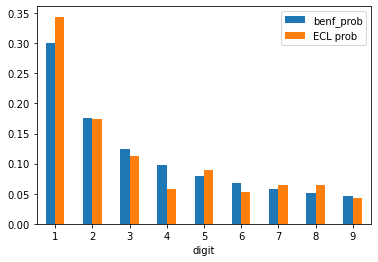

Goodness of fit for ECL is  18.533059531806636
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

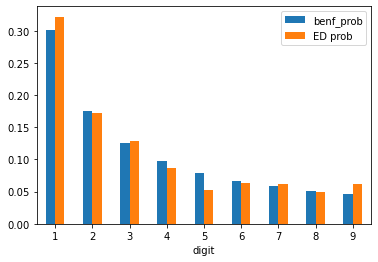

Goodness of fit for ED is  9.779961633613315
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

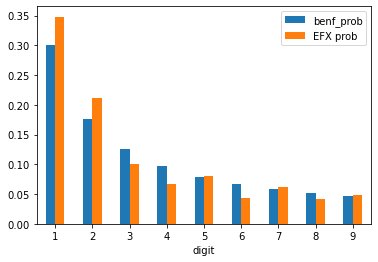

Goodness of fit for EFX is  22.059793026827606
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

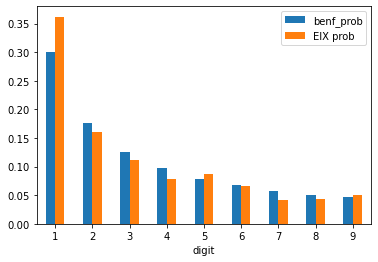

Goodness of fit for EIX is  14.858275829335751
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for EL is  6.744306638780232
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

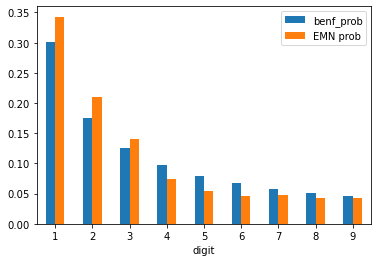

Goodness of fit for EMN is  21.012845634454358
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for EMR is  10.686536422899565
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for ENPH is  24.343551856650873
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

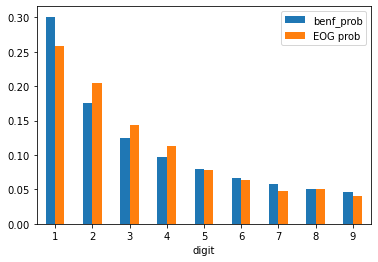

Goodness of fit for EOG is  10.367963924692841
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for EPAM is  22.487943739399928
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

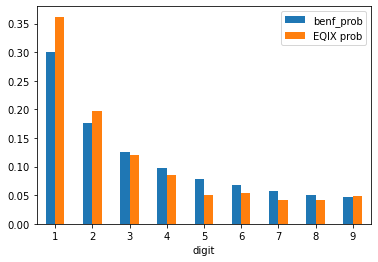

Goodness of fit for EQIX is  21.01478298312538
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

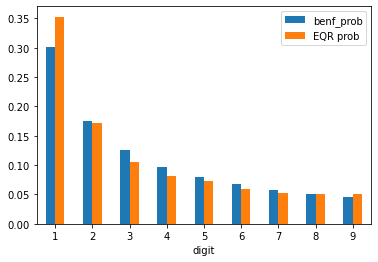

Goodness of fit for EQR is  9.089667358381625
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

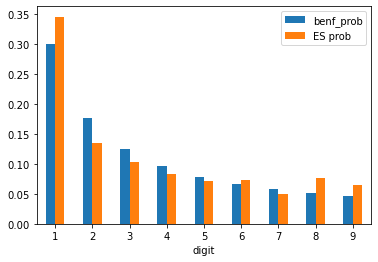

Goodness of fit for ES is  24.86711795797242
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

Goodness of fit for ESS is  15.909503293547036
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for ETN is  9.002517767063415
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for ETR is  13.920538714820351
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

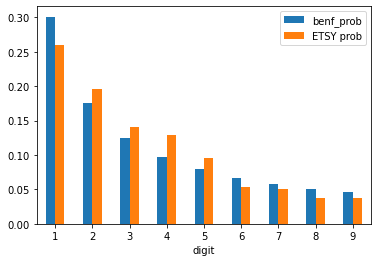

Goodness of fit for ETSY is  18.611977688008295
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

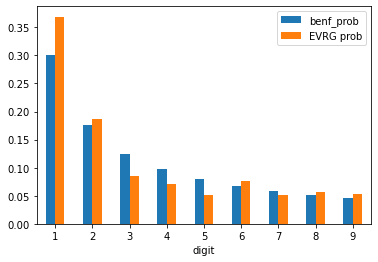

Goodness of fit for EVRG is  27.647771975093715
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

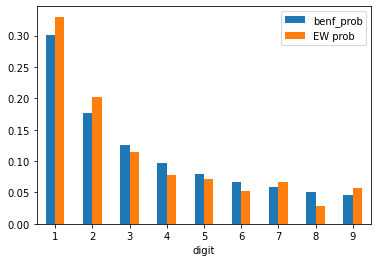

Goodness of fit for EW is  16.44205701788256
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

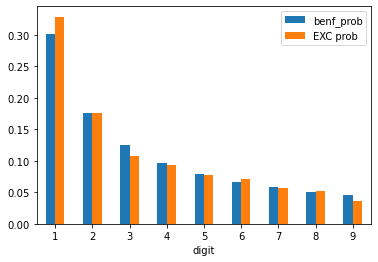

Goodness of fit for EXC is  4.5098373993985
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

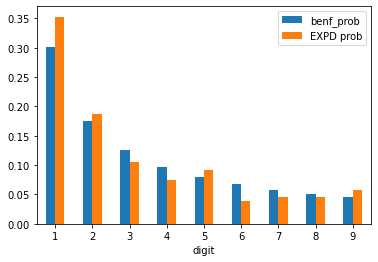

Goodness of fit for EXPD is  20.93984959874893
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

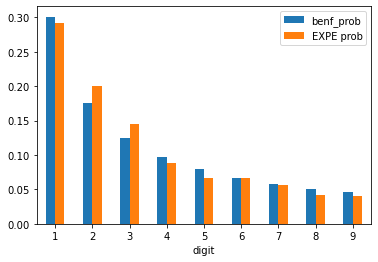

Goodness of fit for EXPE is  6.6760067669023995
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

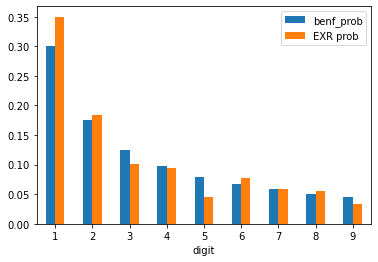

Goodness of fit for EXR is  18.310558126412893
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

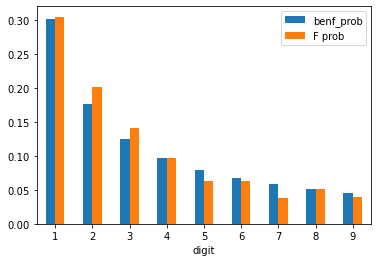

Goodness of fit for F is  9.504104262780007
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

Goodness of fit for FANG is  13.547219087388788
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for FAST is  27.695171777249335
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

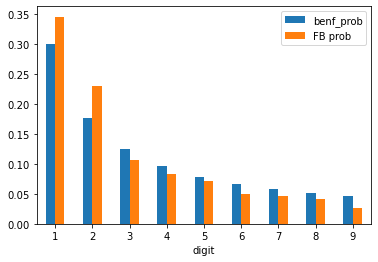

Goodness of fit for FB is  25.906504644370308
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

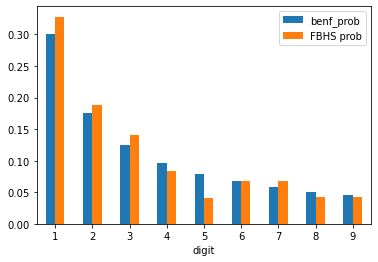

Goodness of fit for FBHS is  16.154740679649084
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for FCX is  25.364166846437314
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for FDS is  11.3973383759475
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

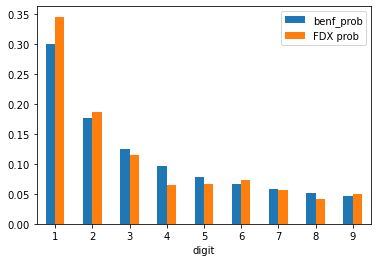

Goodness of fit for FDX is  13.260412383443951
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for FE is  7.770452069317674
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

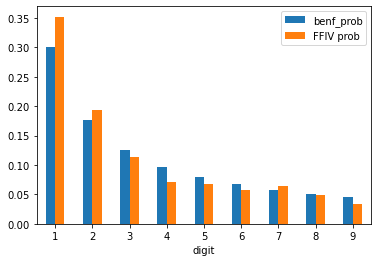

Goodness of fit for FFIV is  14.266300849603851
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

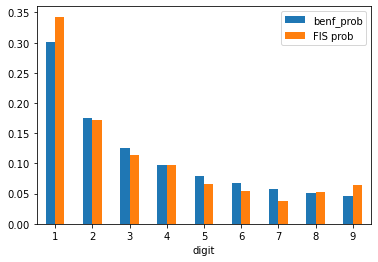

Goodness of fit for FIS is  14.450408084782408
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

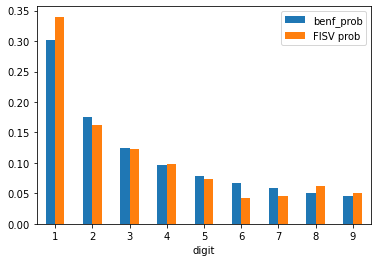

Goodness of fit for FISV is  11.576159862928144
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

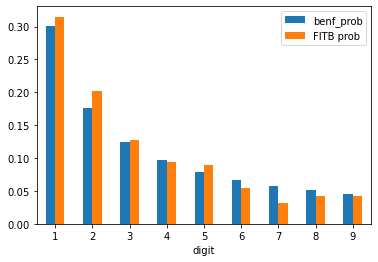

Goodness of fit for FITB is  12.351377589936467
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

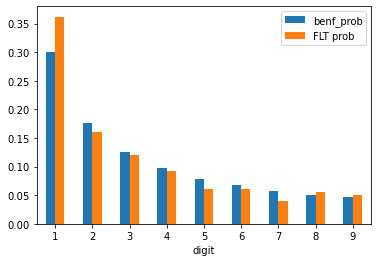

Goodness of fit for FLT is  15.085833030415914
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

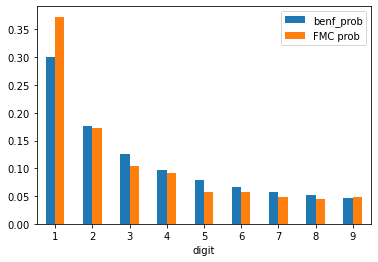

Goodness of fit for FMC is  17.146910648045964
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

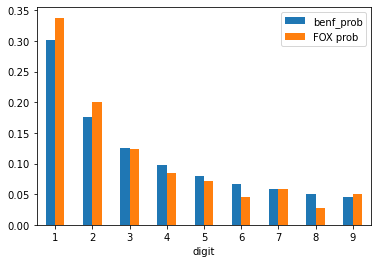

Goodness of fit for FOX is  15.326927787853245
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

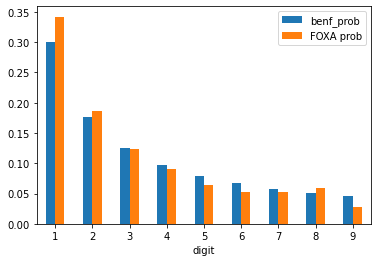

Goodness of fit for FOXA is  12.289884593975323
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

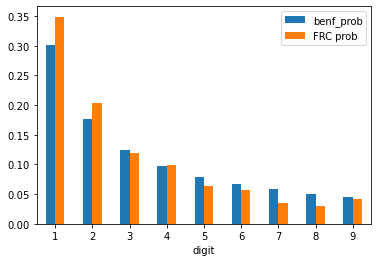

Goodness of fit for FRC is  19.373628461891254
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for FRT is  8.360652250116967
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for FTNT is  16.790181489172202
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

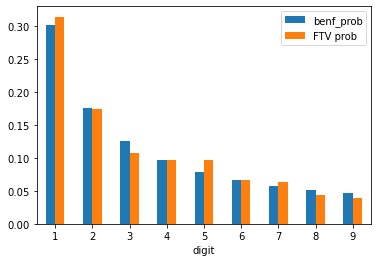

Goodness of fit for FTV is  5.335832520255622
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

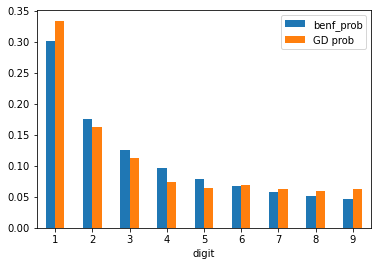

Goodness of fit for GD is  12.168271446590078
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

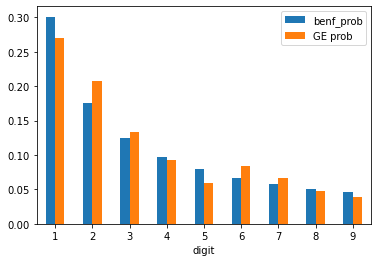

Goodness of fit for GE is  12.049576791624517
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

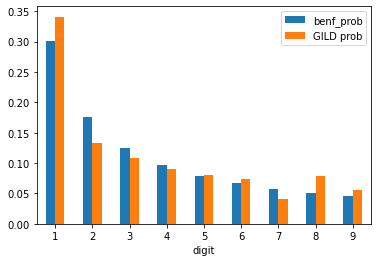

Goodness of fit for GILD is  22.629952056297007
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

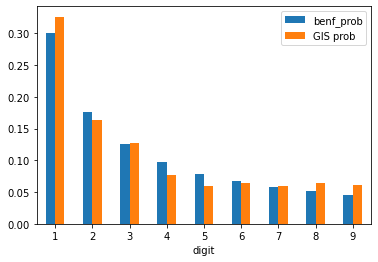

Goodness of fit for GIS is  11.524164420258764
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

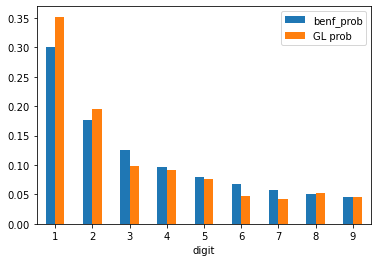

Goodness of fit for GL is  14.997909781417603
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

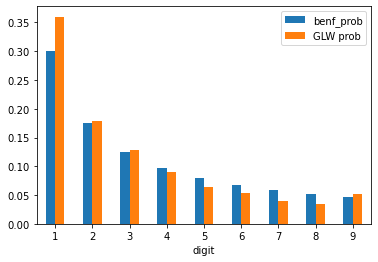

Goodness of fit for GLW is  17.307453498310107
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for GM is  15.261530100699641
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for GNRC is  13.890527839435752
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

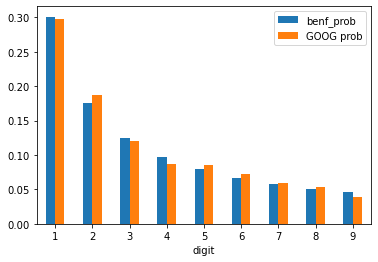

Goodness of fit for GOOG is  2.3866959514415846
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

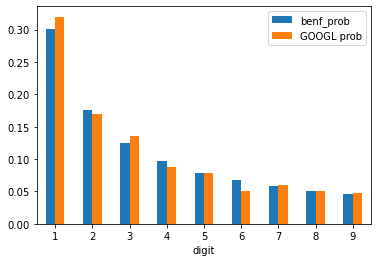

Goodness of fit for GOOGL is  4.170264686795942
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

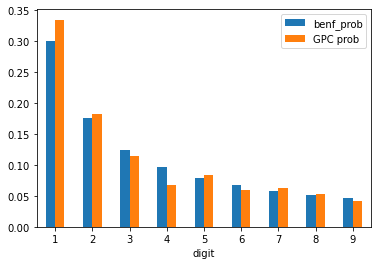

Goodness of fit for GPC is  8.707380358549505
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

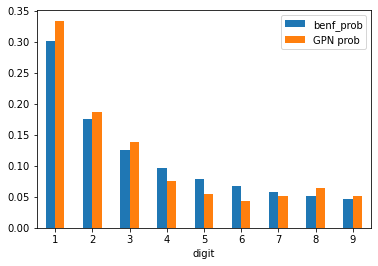

Goodness of fit for GPN is  16.926628866039607
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

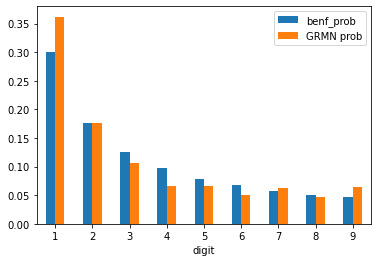

Goodness of fit for GRMN is  21.853860783896895
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

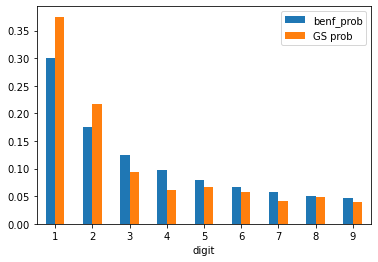

Goodness of fit for GS is  32.858213387764
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732838

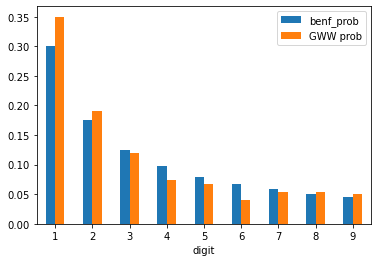

Goodness of fit for GWW is  15.668890838130157
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

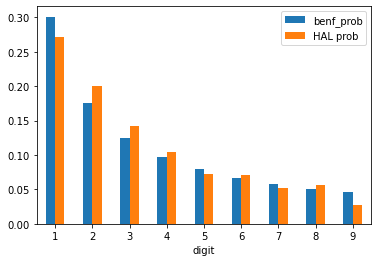

Goodness of fit for HAL is  11.020128415197032
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

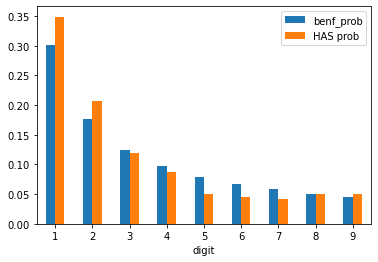

Goodness of fit for HAS is  20.95597637285702
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

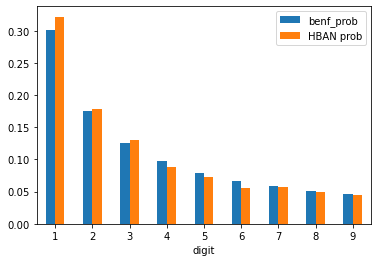

Goodness of fit for HBAN is  2.86117656698809
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for HCA is  4.37305974084813
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

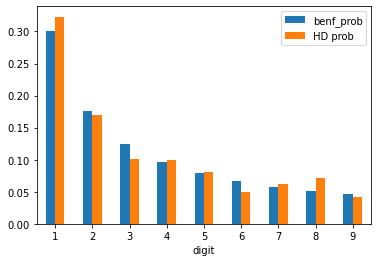

Goodness of fit for HD is  11.798913863437887
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

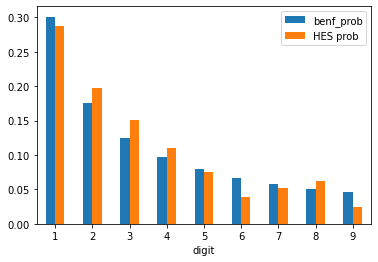

Goodness of fit for HES is  19.652465124042976
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

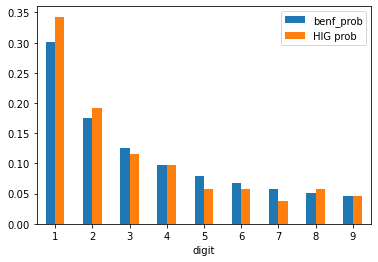

Goodness of fit for HIG is  13.047284756172337
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

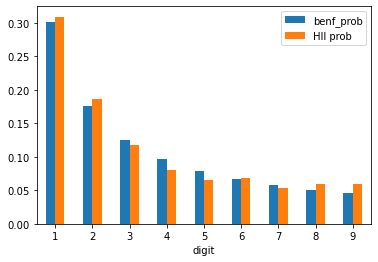

Goodness of fit for HII is  7.133593252115864
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

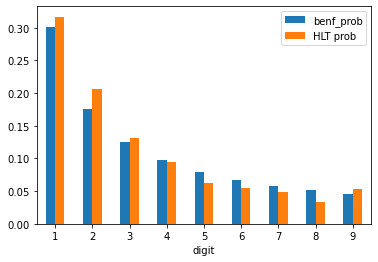

Goodness of fit for HLT is  12.090095465493954
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

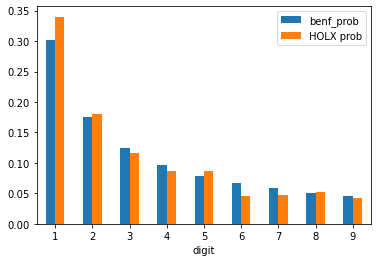

Goodness of fit for HOLX is  9.05313329855933
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

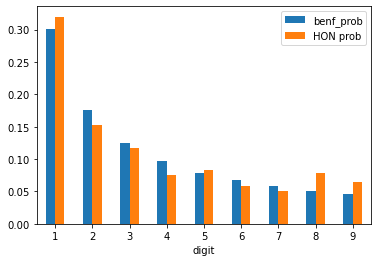

Goodness of fit for HON is  19.473922871300296
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

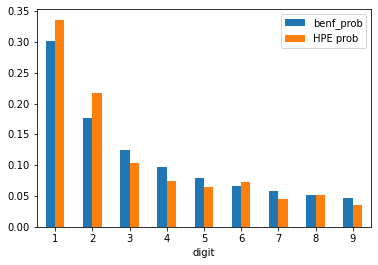

Goodness of fit for HPE is  17.242095635207033
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

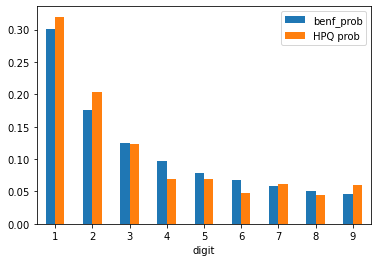

Goodness of fit for HPQ is  14.604692379078749
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

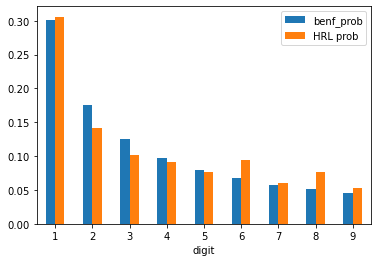

Goodness of fit for HRL is  20.978585068411316
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

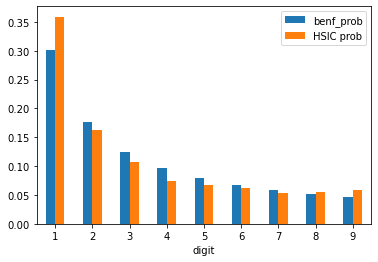

Goodness of fit for HSIC is  14.68080404110007
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

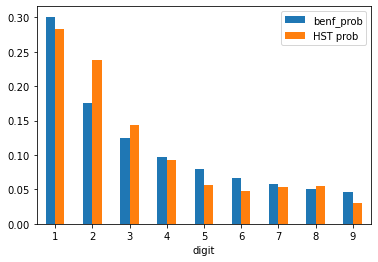

Goodness of fit for HST is  24.566032986607762
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

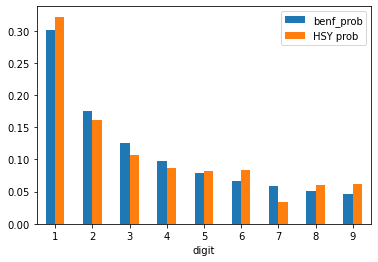

Goodness of fit for HSY is  15.79438435108408
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

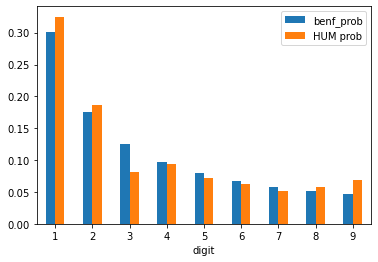

Goodness of fit for HUM is  18.2514115955955
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

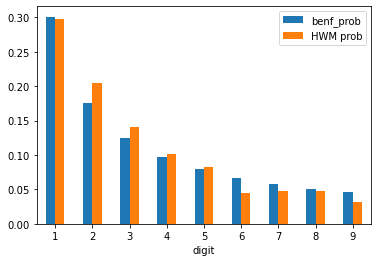

Goodness of fit for HWM is  11.618726605902598
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

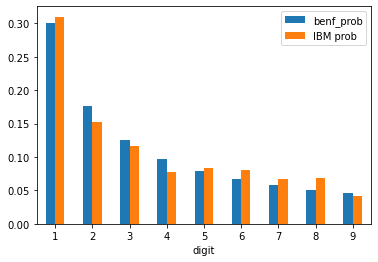

Goodness of fit for IBM is  10.857719187378336
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

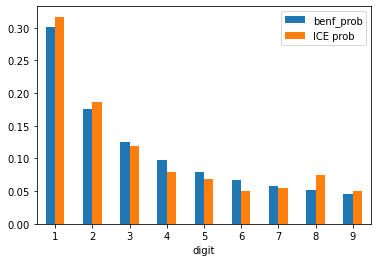

Goodness of fit for ICE is  12.301729191900753
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

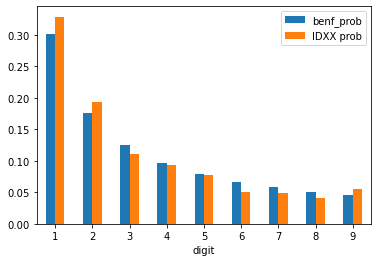

Goodness of fit for IDXX is  8.19255202796854
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

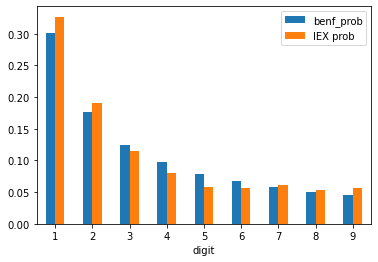

Goodness of fit for IEX is  9.779371910534334
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

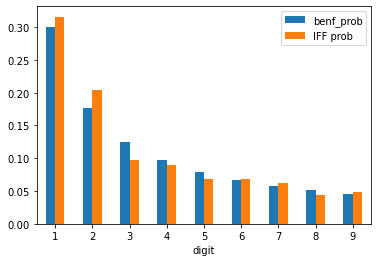

Goodness of fit for IFF is  8.147024155921175
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

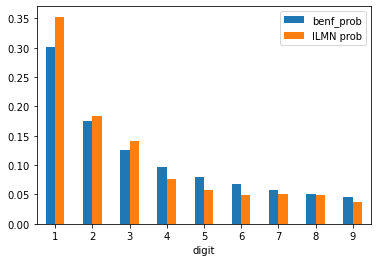

Goodness of fit for ILMN is  16.248365332855514
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

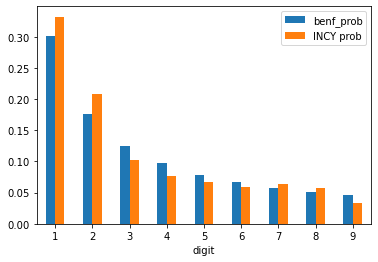

Goodness of fit for INCY is  13.787996264450628
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

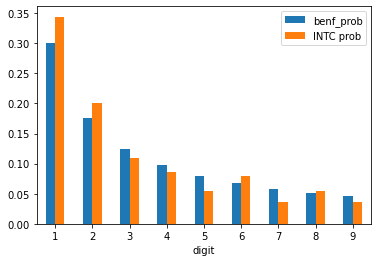

Goodness of fit for INTC is  18.978456094638396
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

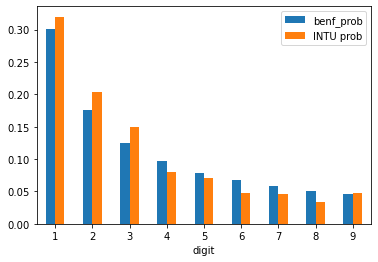

Goodness of fit for INTU is  16.19302145307453
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

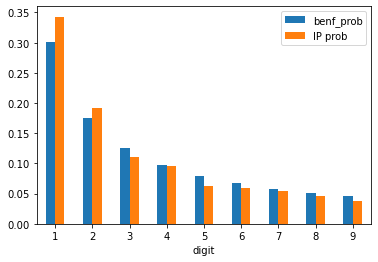

Goodness of fit for IP is  8.724403269083327
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

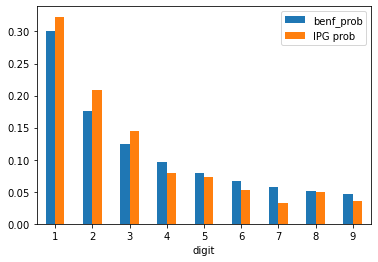

Goodness of fit for IPG is  17.16212876255092
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

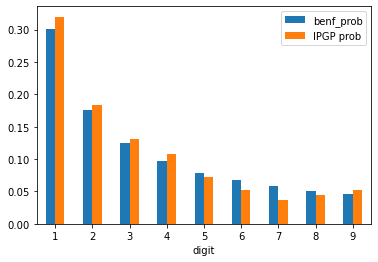

Goodness of fit for IPGP is  9.042821664996632
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

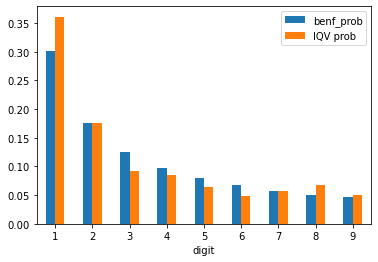

Goodness of fit for IQV is  20.60775298746582
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

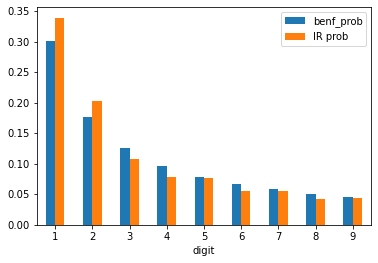

Goodness of fit for IR is  10.7076271491082
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

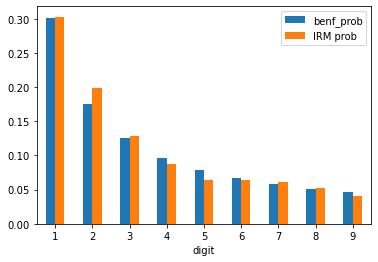

Goodness of fit for IRM is  4.187145015741756
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

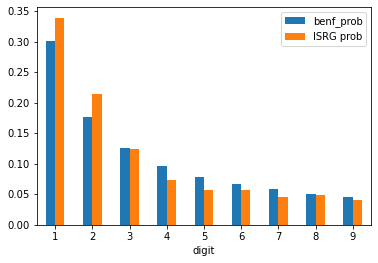

Goodness of fit for ISRG is  16.717591249223243
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

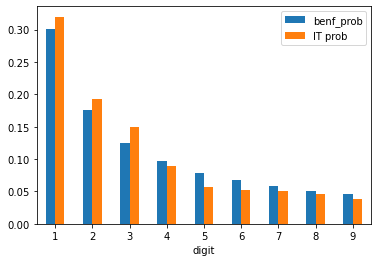

Goodness of fit for IT is  11.340086013990529
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

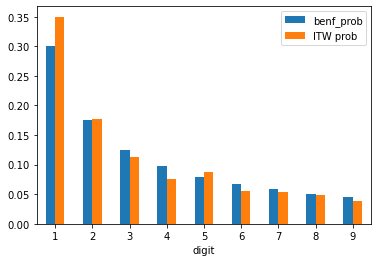

Goodness of fit for ITW is  10.60324959913507
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

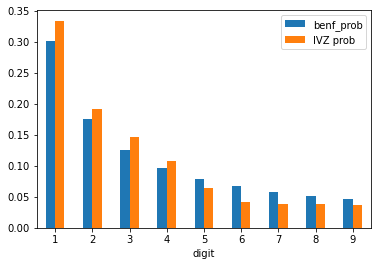

Goodness of fit for IVZ is  18.829564459805795
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

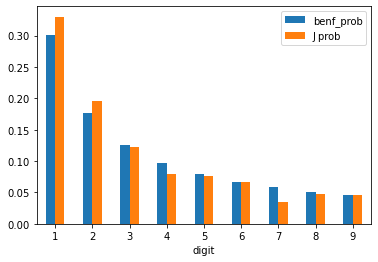

Goodness of fit for J is  9.953487375289917
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

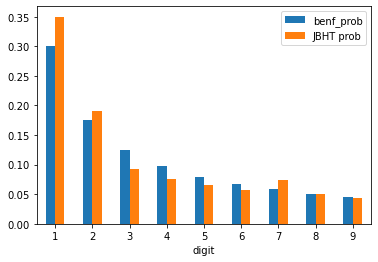

Goodness of fit for JBHT is  17.65207925187296
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

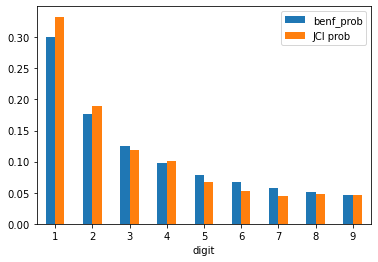

Goodness of fit for JCI is  7.313021873011054
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for JKHY is  16.377494201484417
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for JNJ is  13.211553464541302
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

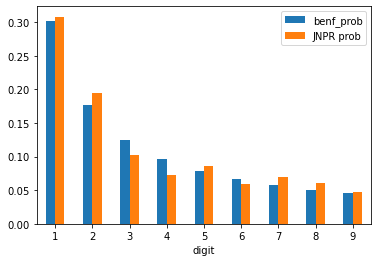

Goodness of fit for JNPR is  10.084146848006602
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

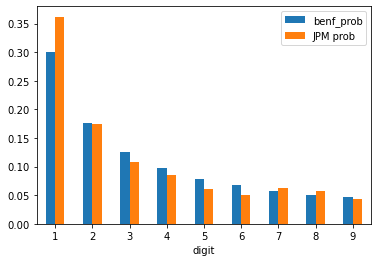

Goodness of fit for JPM is  14.729006096221188
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

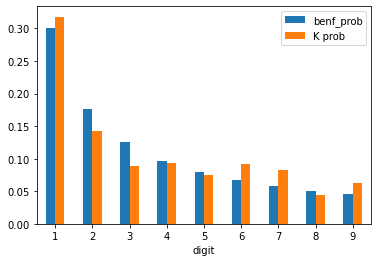

Goodness of fit for K is  25.68520560007504
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

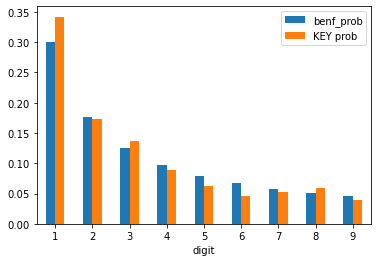

Goodness of fit for KEY is  11.384573272715723
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

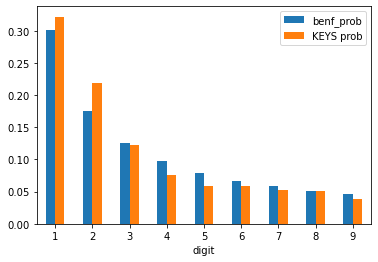

Goodness of fit for KEYS is  13.987118087944767
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

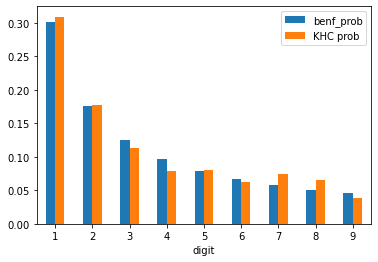

Goodness of fit for KHC is  9.140495413868067
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

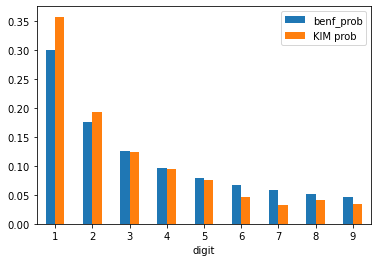

Goodness of fit for KIM is  19.588216100089802
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

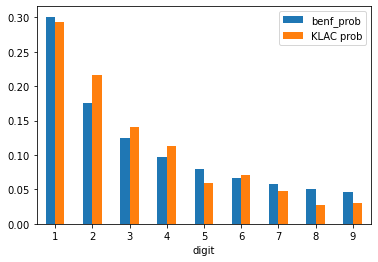

Goodness of fit for KLAC is  20.31947054723955
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

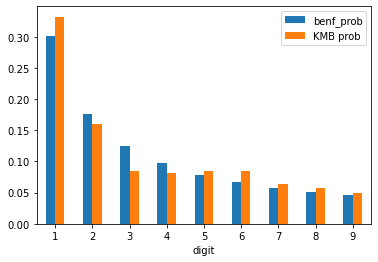

Goodness of fit for KMB is  15.08986479534742
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

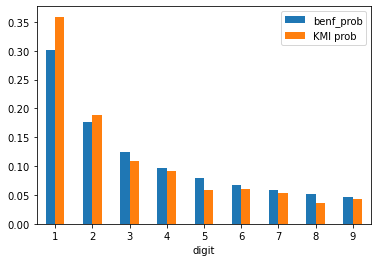

Goodness of fit for KMI is  14.226058352212515
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

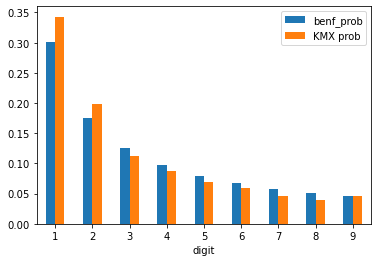

Goodness of fit for KMX is  10.492098975989494
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

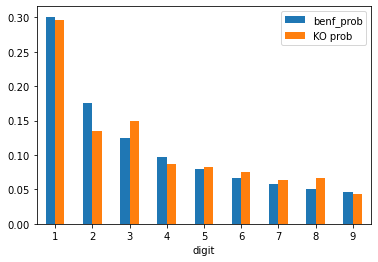

Goodness of fit for KO is  12.774075953370302
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

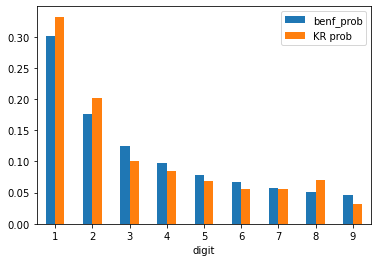

Goodness of fit for KR is  16.707083408577773
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

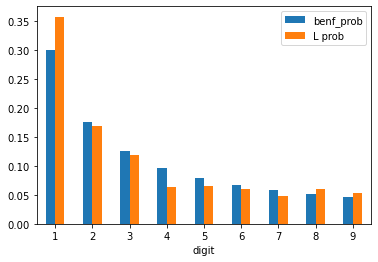

Goodness of fit for L is  16.820891333065937
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

Goodness of fit for LDOS is  13.787193450313255
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

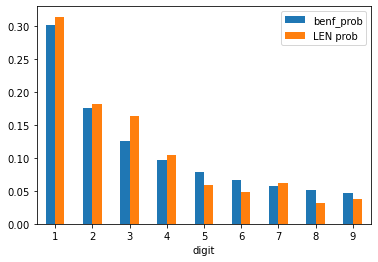

Goodness of fit for LEN is  18.484548360063464
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for LH is  17.63542311623259
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

Goodness of fit for LHX is  17.410911522396624
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for LIN is  9.794292017770392
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for LKQ is  23.488170562169262
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

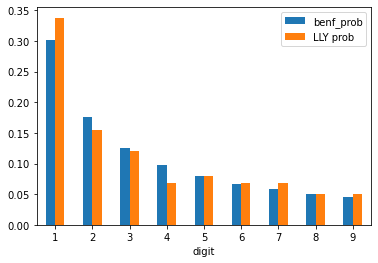

Goodness of fit for LLY is  10.167514933703561
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for LMT is  22.998200098446546
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

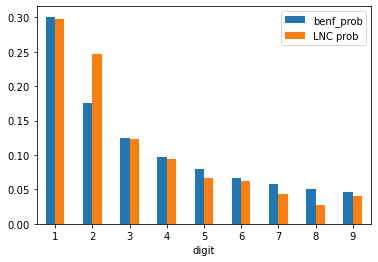

Goodness of fit for LNC is  25.886315038791594
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for LNT is  17.474408635572125
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

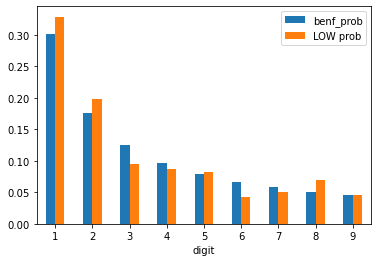

Goodness of fit for LOW is  16.80636660111916
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

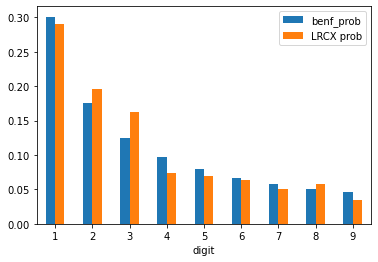

Goodness of fit for LRCX is  14.506218450993632
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for LUMN is  12.286018420378678
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for LUV is  9.234037854295327
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

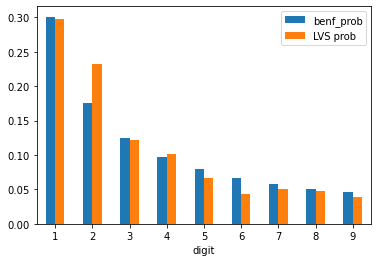

Goodness of fit for LVS is  17.67475733033155
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for LW is  12.185619557369957
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for LYB is  13.487319000397061
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for LYV is  16.237826608337354
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

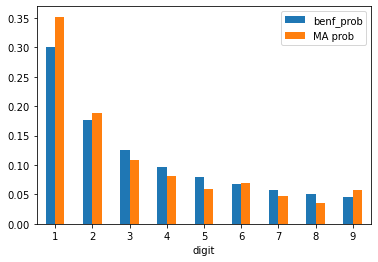

Goodness of fit for MA is  16.365323589793874
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

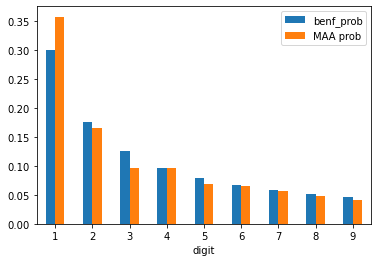

Goodness of fit for MAA is  10.767440403573316
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

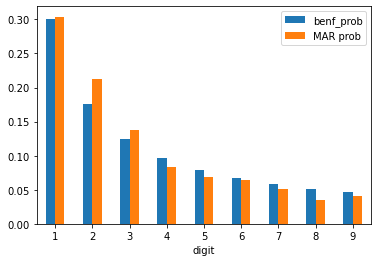

Goodness of fit for MAR is  10.35969842998986
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for MAS is  11.908085552869068
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MCD is  14.488271556215885
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

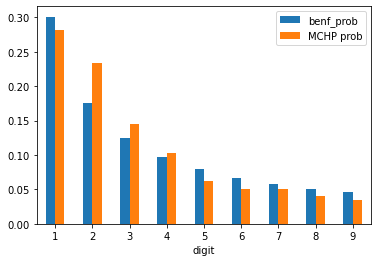

Goodness of fit for MCHP is  21.298460176096096
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

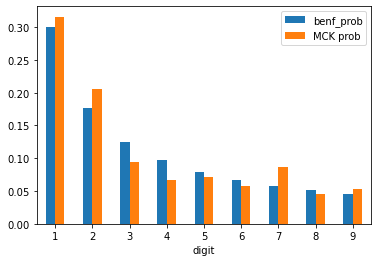

Goodness of fit for MCK is  22.103413088775426
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MCO is  18.22250647259258
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

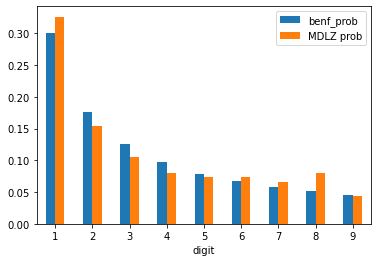

Goodness of fit for MDLZ is  16.59948885759731
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

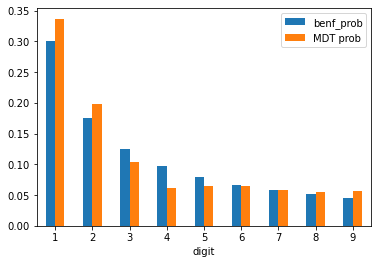

Goodness of fit for MDT is  16.157588684640515
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

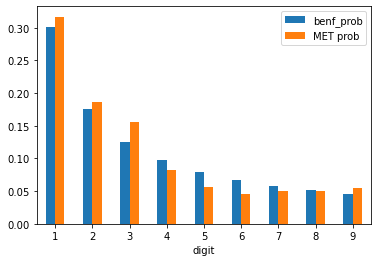

Goodness of fit for MET is  15.163862794731848
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

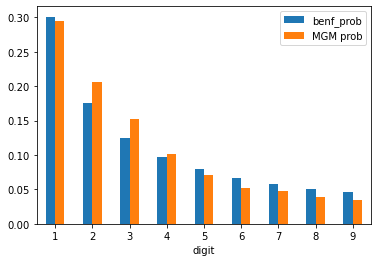

Goodness of fit for MGM is  13.405613200011976
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MHK is  24.862429049796155
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MKC is  25.410376725768188
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

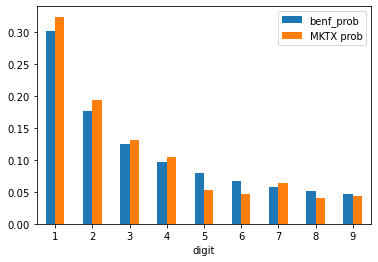

Goodness of fit for MKTX is  12.426029024073829
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for MLM is  17.689764379962412
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

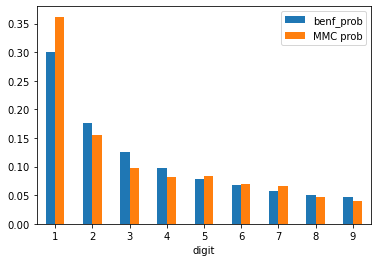

Goodness of fit for MMC is  14.838114105412822
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

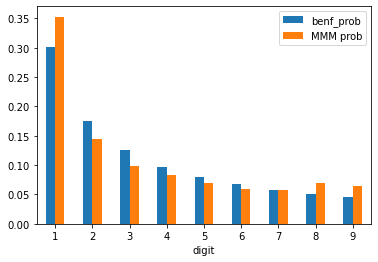

Goodness of fit for MMM is  20.98994205617172
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for MNST is  8.513846257888833
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

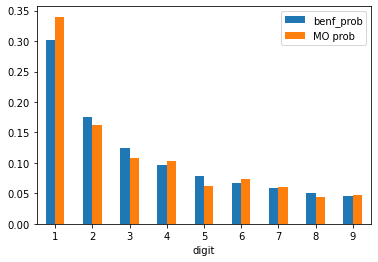

Goodness of fit for MO is  7.81544450020315
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

Goodness of fit for MOH is  17.518989501849433
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

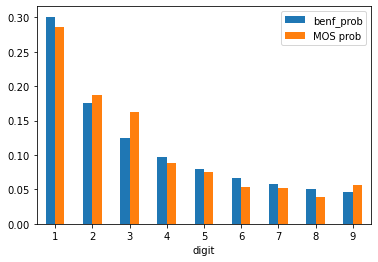

Goodness of fit for MOS is  12.944113302302801
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

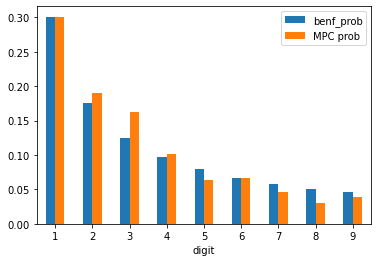

Goodness of fit for MPC is  15.703454049530626
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MPWR is  19.203086736040174
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

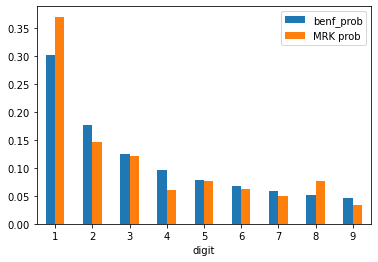

Goodness of fit for MRK is  29.1541462666525
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

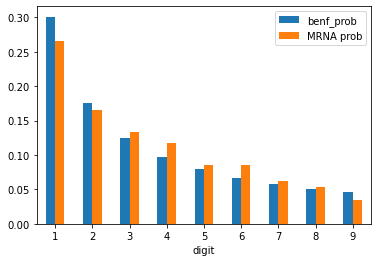

Goodness of fit for MRNA is  9.757261184289025
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

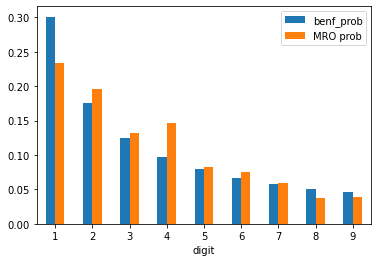

Goodness of fit for MRO is  27.143859222599005
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

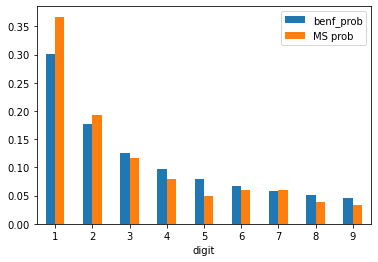

Goodness of fit for MS is  21.163636223212553
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

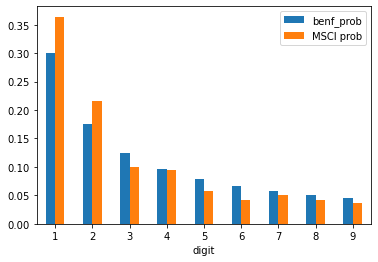

Goodness of fit for MSCI is  27.17698138708066
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

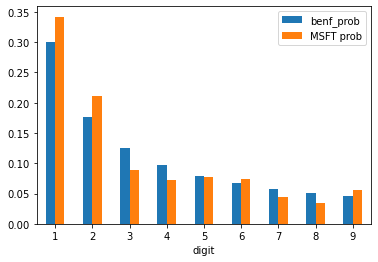

Goodness of fit for MSFT is  23.094396909481777
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for MSI is  8.261051103423512
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

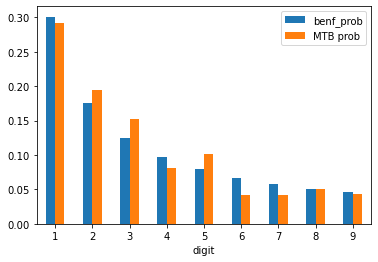

Goodness of fit for MTB is  16.938186196529507
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for MTCH is  22.179464611105146
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

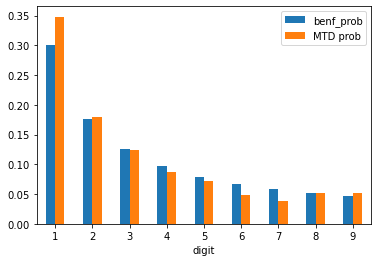

Goodness of fit for MTD is  12.226994502427189
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

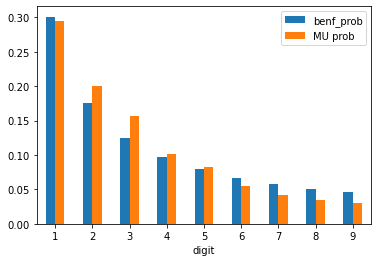

Goodness of fit for MU is  16.544750589091386
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

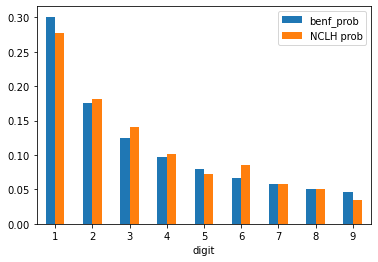

Goodness of fit for NCLH is  6.570709999297798
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

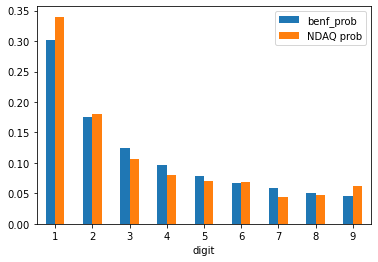

Goodness of fit for NDAQ is  11.84381843129357
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

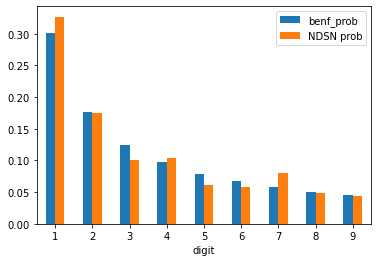

Goodness of fit for NDSN is  11.56850879332913
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

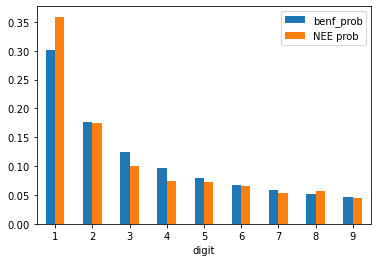

Goodness of fit for NEE is  12.915176434006314
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

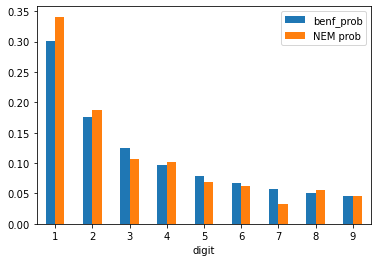

Goodness of fit for NEM is  13.035150174396044
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

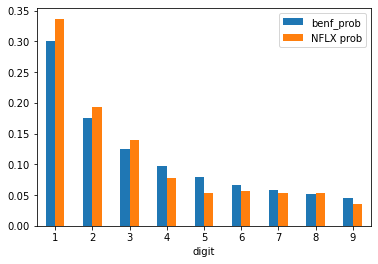

Goodness of fit for NFLX is  14.162611244464445
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

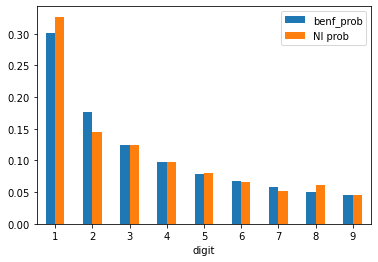

Goodness of fit for NI is  5.834495018871806
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

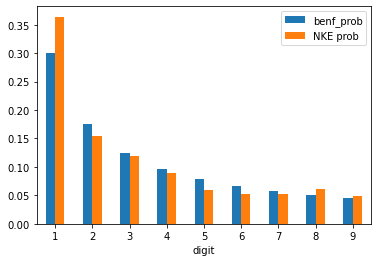

Goodness of fit for NKE is  15.794674995159891
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

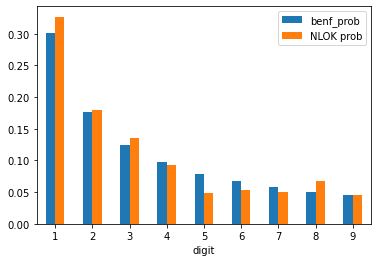

Goodness of fit for NLOK is  13.880525946345474
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

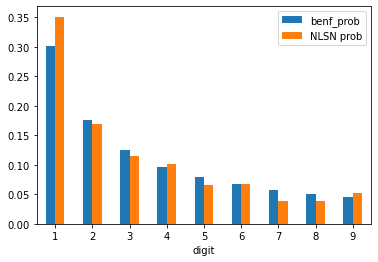

Goodness of fit for NLSN is  12.611036973075077
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

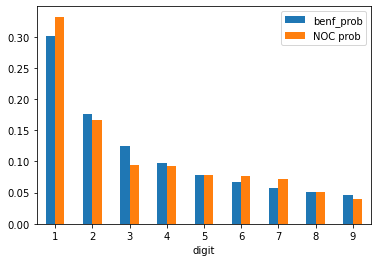

Goodness of fit for NOC is  10.100351401928034
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

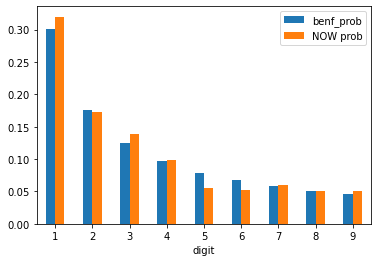

Goodness of fit for NOW is  7.695834499334125
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

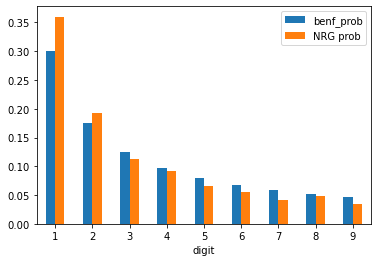

Goodness of fit for NRG is  15.355887614555934
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

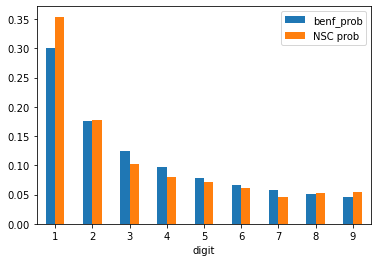

Goodness of fit for NSC is  12.393129483439793
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

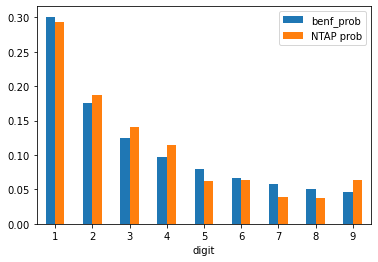

Goodness of fit for NTAP is  14.7278271951575
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

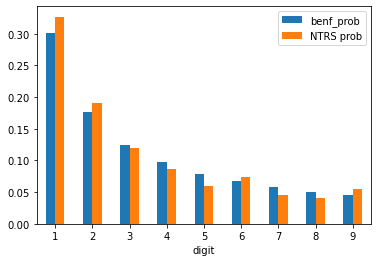

Goodness of fit for NTRS is  9.375077719963361
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

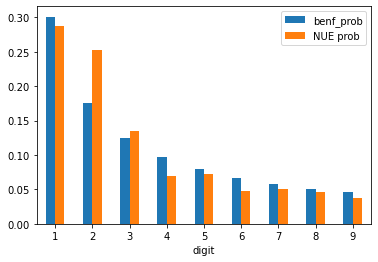

Goodness of fit for NUE is  29.417613931458924
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

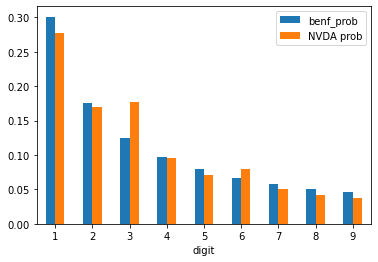

Goodness of fit for NVDA is  17.639324220052544
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

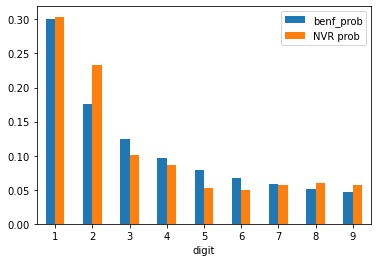

Goodness of fit for NVR is  23.588158748381005
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

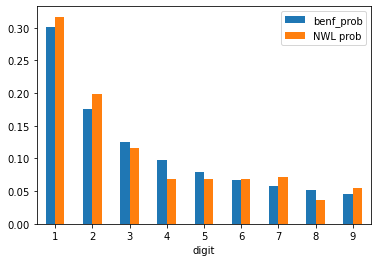

Goodness of fit for NWL is  12.681295377504789
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

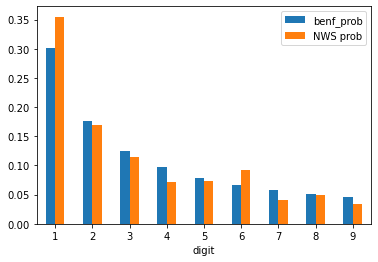

Goodness of fit for NWS is  20.254533394846465
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

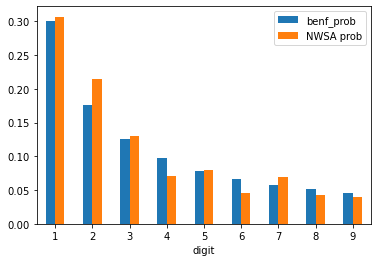

Goodness of fit for NWSA is  14.745454196898343
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

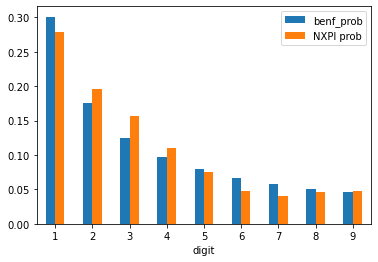

Goodness of fit for NXPI is  14.297708273768702
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

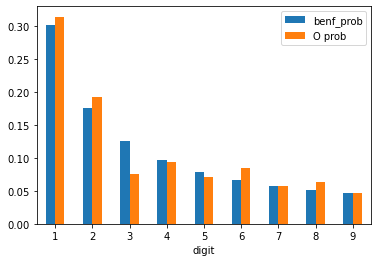

Goodness of fit for O is  16.94735380066357
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

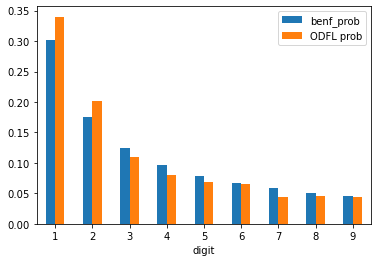

Goodness of fit for ODFL is  10.654299959985146
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

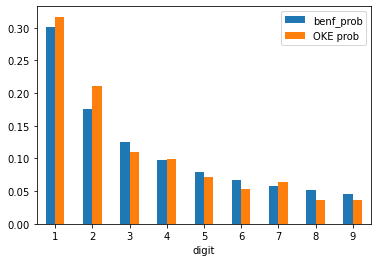

Goodness of fit for OKE is  10.921050483449399
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

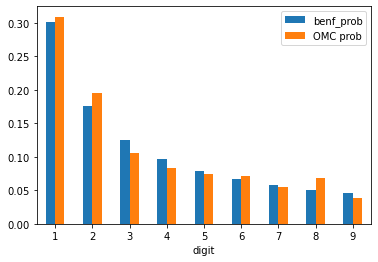

Goodness of fit for OMC is  8.83662851538822
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

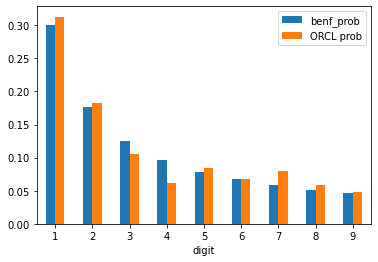

Goodness of fit for ORCL is  14.603688486866963
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

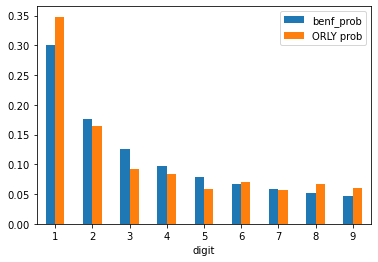

Goodness of fit for ORLY is  19.23946285550423
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

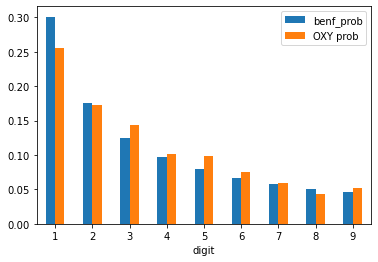

Goodness of fit for OXY is  10.037496561679214
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

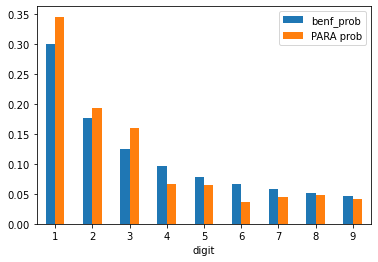

Goodness of fit for PARA is  26.84279277091564
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

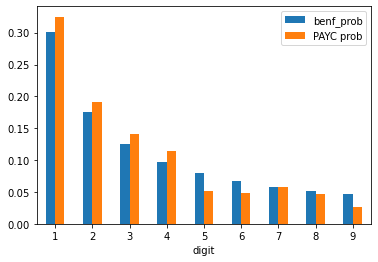

Goodness of fit for PAYC is  18.514803846027856
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

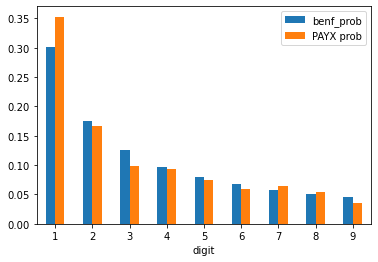

Goodness of fit for PAYX is  11.046176805661652
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

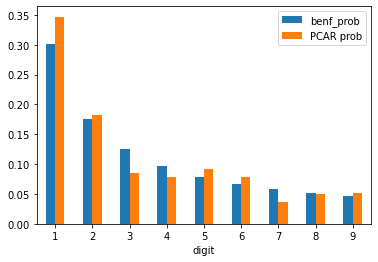

Goodness of fit for PCAR is  20.272664486192618
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

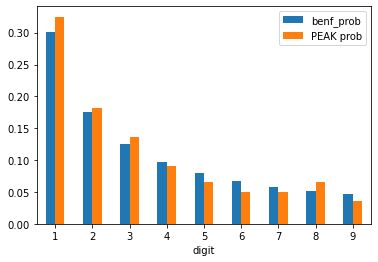

Goodness of fit for PEAK is  10.189774130445983
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

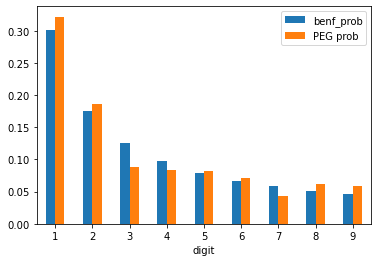

Goodness of fit for PEG is  13.428048023816002
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

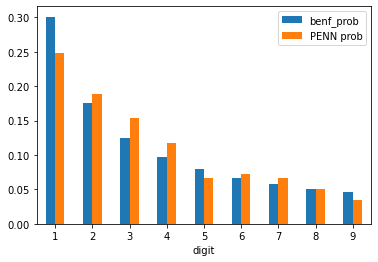

Goodness of fit for PENN is  15.031444034029382
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

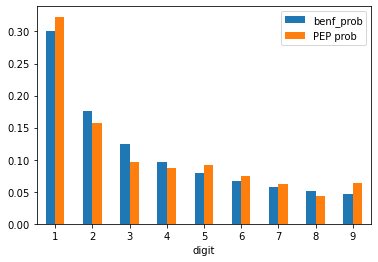

Goodness of fit for PEP is  12.372440971541788
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

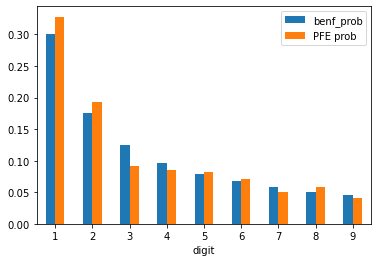

Goodness of fit for PFE is  10.029054554755986
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

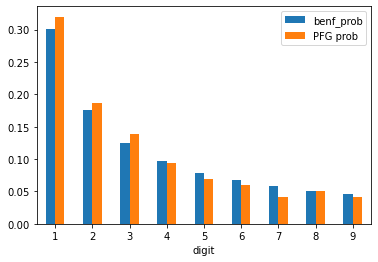

Goodness of fit for PFG is  5.661627088880104
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

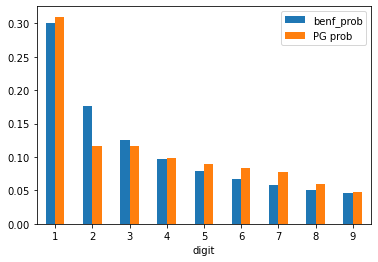

Goodness of fit for PG is  19.099077014126465
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

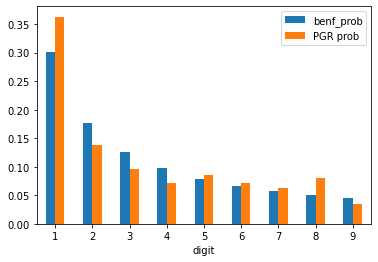

Goodness of fit for PGR is  30.710346083751208
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

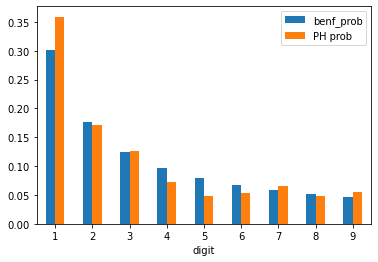

Goodness of fit for PH is  19.361939308628468
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

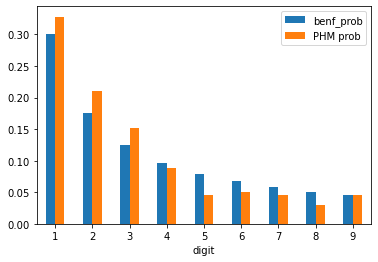

Goodness of fit for PHM is  25.064599594951115
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

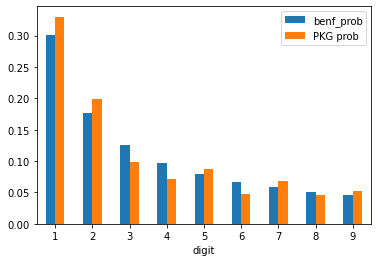

Goodness of fit for PKG is  16.180335232807863
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

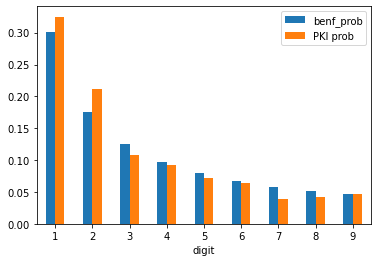

Goodness of fit for PKI is  11.556957235895402
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

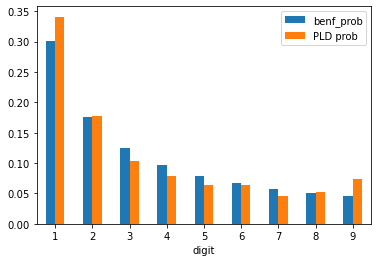

Goodness of fit for PLD is  20.173461955956967
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

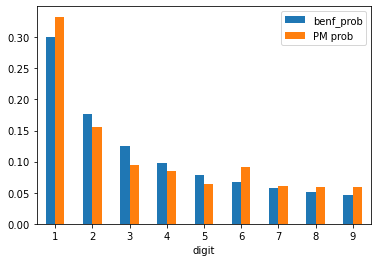

Goodness of fit for PM is  17.341968662319367
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

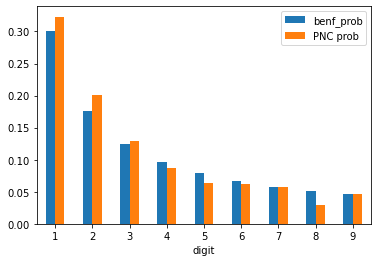

Goodness of fit for PNC is  10.521994546568928
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

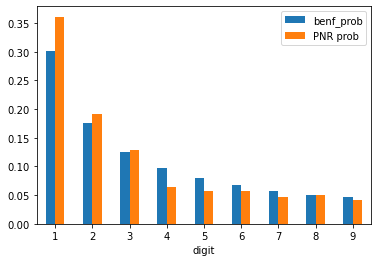

Goodness of fit for PNR is  19.27024825012653
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

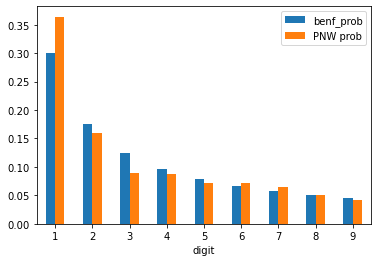

Goodness of fit for PNW is  15.409604629497036
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

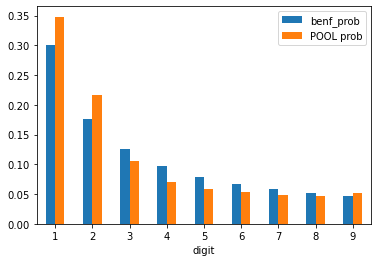

Goodness of fit for POOL is  21.386970731541346
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

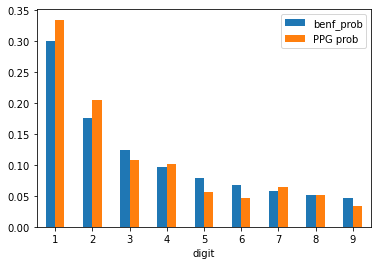

Goodness of fit for PPG is  15.754401286509411
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

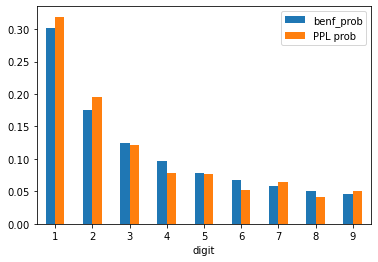

Goodness of fit for PPL is  7.062529011755354
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

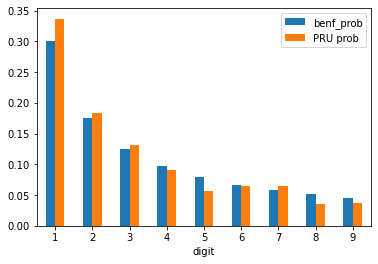

Goodness of fit for PRU is  11.058595306461738
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

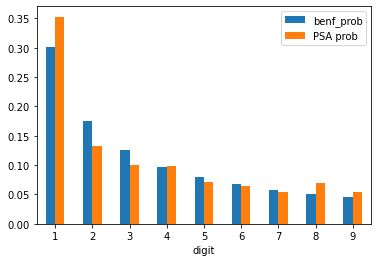

Goodness of fit for PSA is  18.943557420545417
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

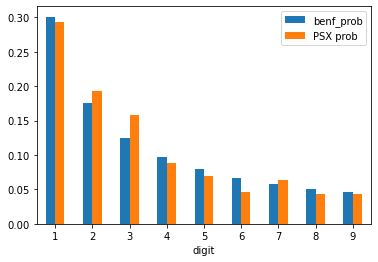

Goodness of fit for PSX is  11.82210816084824
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

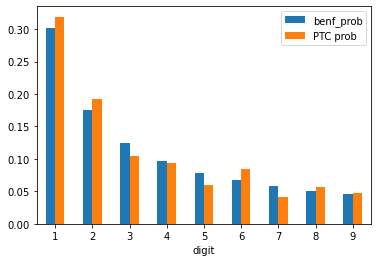

Goodness of fit for PTC is  12.029307834768757
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

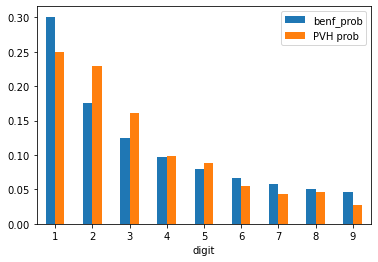

Goodness of fit for PVH is  28.35778145002603
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

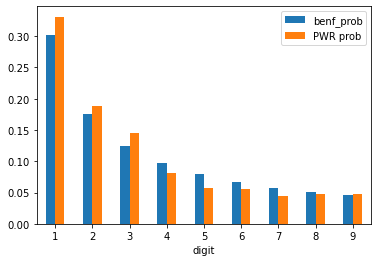

Goodness of fit for PWR is  11.777962122476193
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

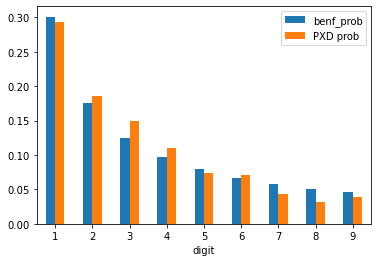

Goodness of fit for PXD is  11.069623904865265
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

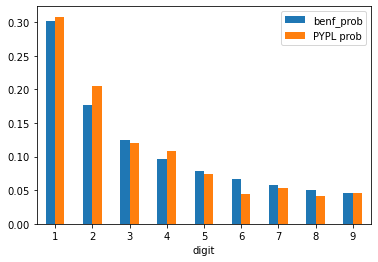

Goodness of fit for PYPL is  9.575225682520367
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

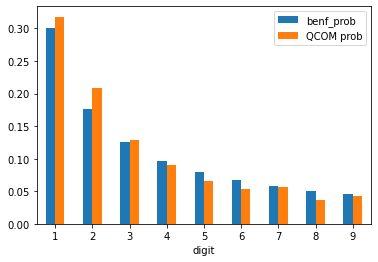

Goodness of fit for QCOM is  9.59573406240208
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

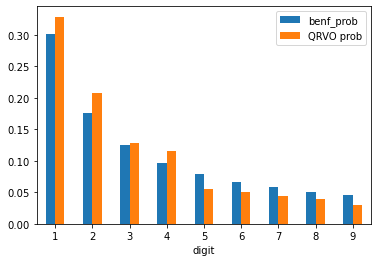

Goodness of fit for QRVO is  19.697309332192035
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

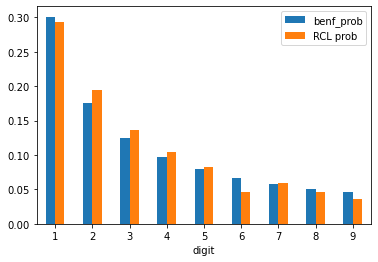

Goodness of fit for RCL is  7.525667695261984
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

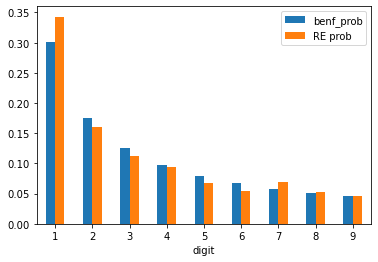

Goodness of fit for RE is  8.210349158935268
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

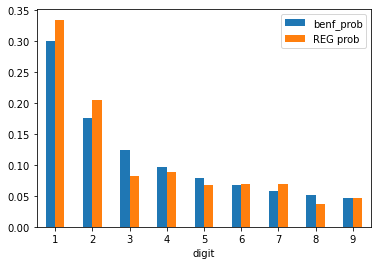

Goodness of fit for REG is  17.736638291070673
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

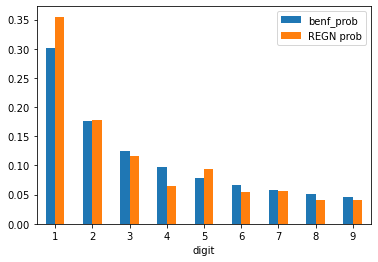

Goodness of fit for REGN is  16.720159748990316
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

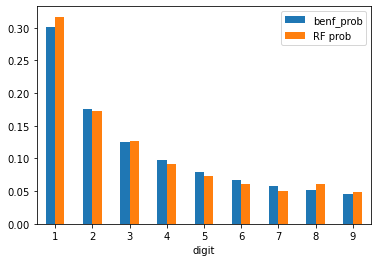

Goodness of fit for RF is  3.044679541985985
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

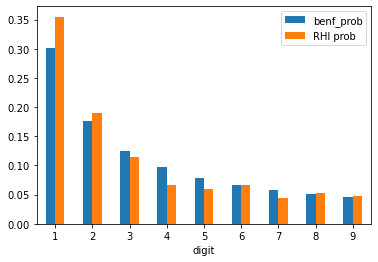

Goodness of fit for RHI is  15.911428389012977
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

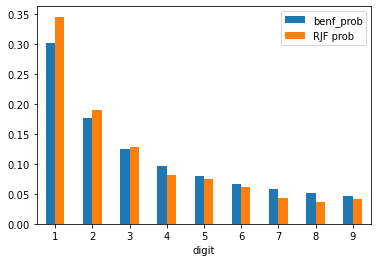

Goodness of fit for RJF is  11.175811643141882
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

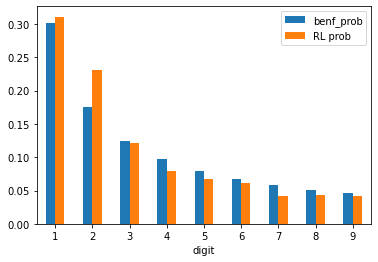

Goodness of fit for RL is  16.382100754507587
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

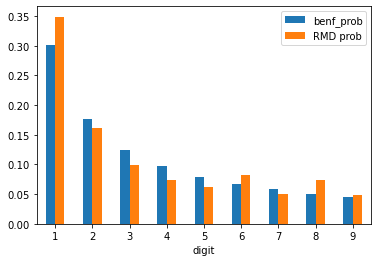

Goodness of fit for RMD is  22.283412100633928
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

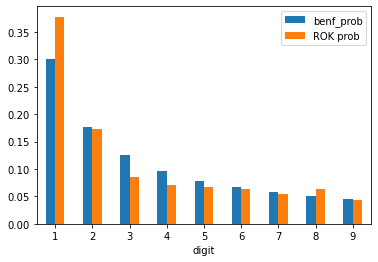

Goodness of fit for ROK is  25.57360056644976
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

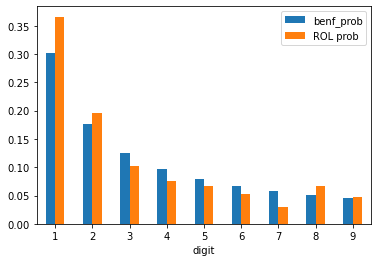

Goodness of fit for ROL is  27.876697133572268
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

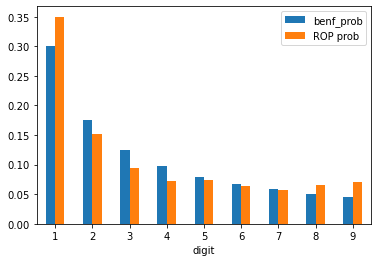

Goodness of fit for ROP is  23.893617007969844
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

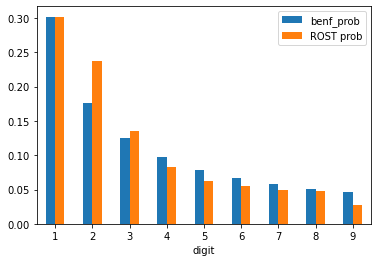

Goodness of fit for ROST is  22.38097381131376
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

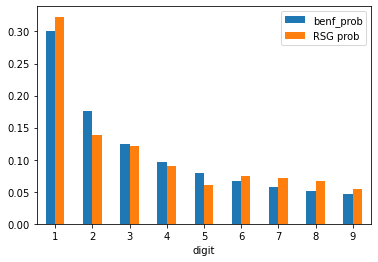

Goodness of fit for RSG is  13.65788038372265
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

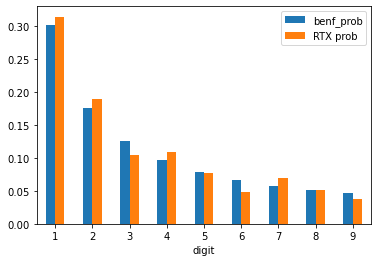

Goodness of fit for RTX is  8.602466441655958
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

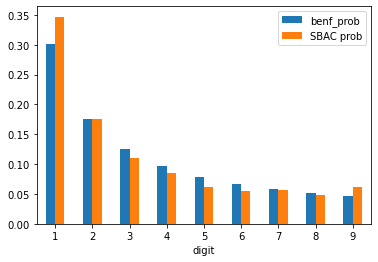

Goodness of fit for SBAC is  12.432428027975295
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

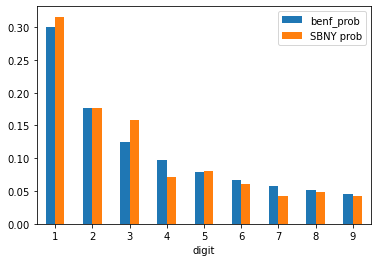

Goodness of fit for SBNY is  12.198671044971956
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for SBUX is  12.551611802926178
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for SCHW is  9.540442681922347
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

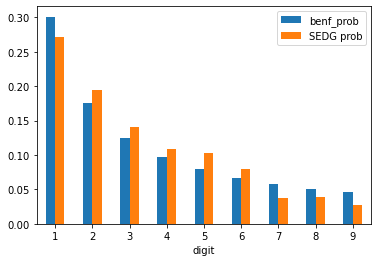

Goodness of fit for SEDG is  19.556831301760607
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

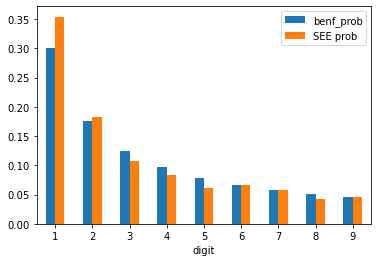

Goodness of fit for SEE is  10.791730114411274
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

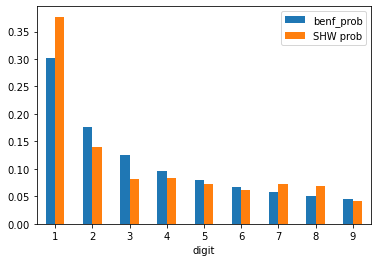

Goodness of fit for SHW is  31.06918259282497
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

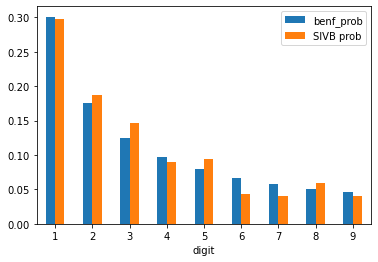

Goodness of fit for SIVB is  12.988446108084261
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

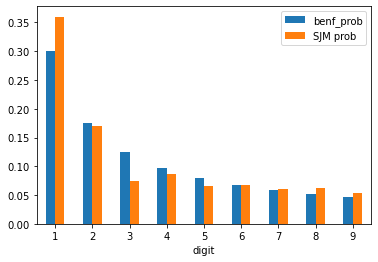

Goodness of fit for SJM is  22.050359706792637
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

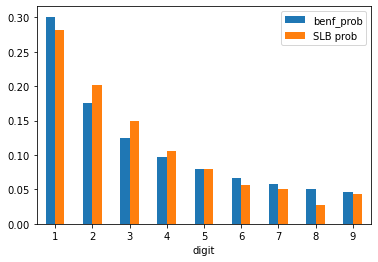

Goodness of fit for SLB is  12.977663514520943
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

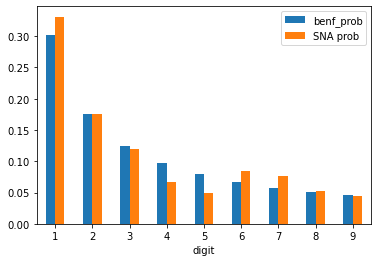

Goodness of fit for SNA is  19.22586495020116
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

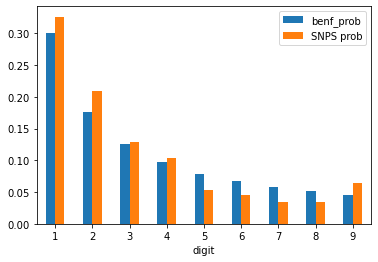

Goodness of fit for SNPS is  24.911528097345606
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

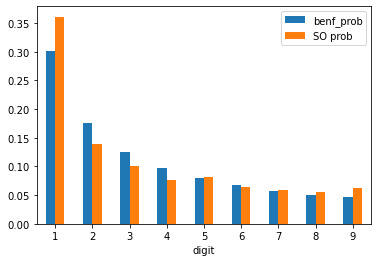

Goodness of fit for SO is  19.684238518894944
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

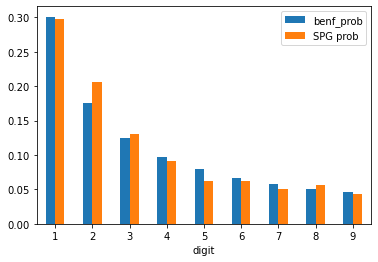

Goodness of fit for SPG is  6.718904778813023
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

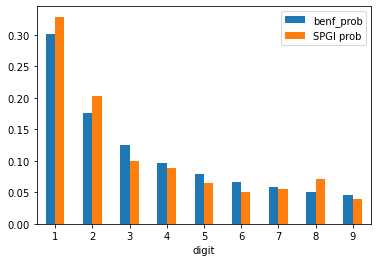

Goodness of fit for SPGI is  15.77513216351743
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

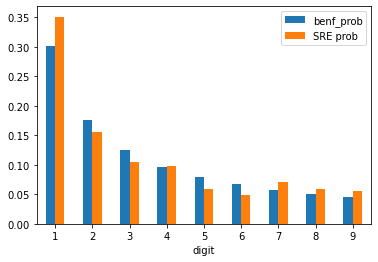

Goodness of fit for SRE is  17.161832887845865
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

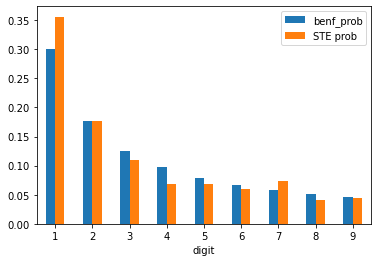

Goodness of fit for STE is  16.413794497310185
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

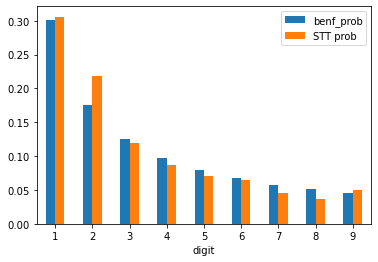

Goodness of fit for STT is  11.091711941559756
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

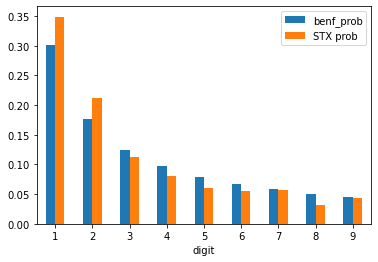

Goodness of fit for STX is  18.984584746458086
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

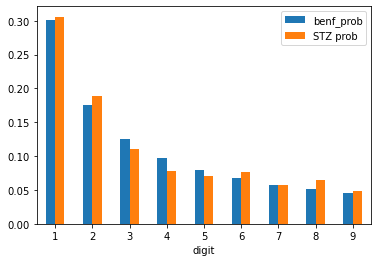

Goodness of fit for STZ is  7.340632210425975
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

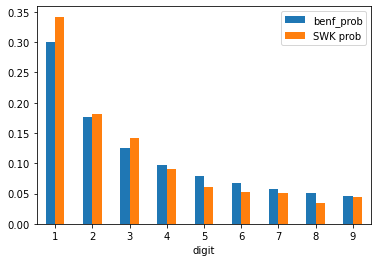

Goodness of fit for SWK is  12.061086080222198
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

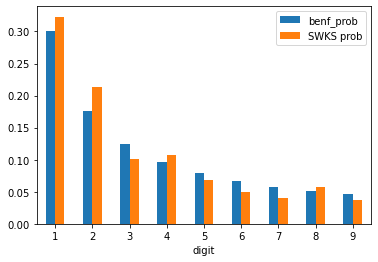

Goodness of fit for SWKS is  16.71149364408166
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

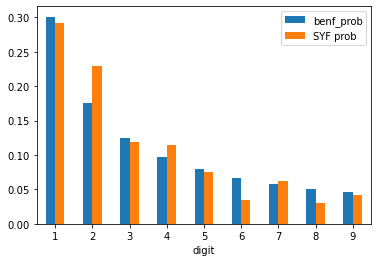

Goodness of fit for SYF is  26.225047313184874
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

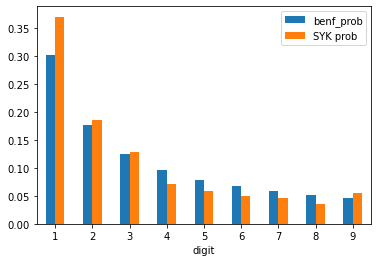

Goodness of fit for SYK is  23.96355544193047
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

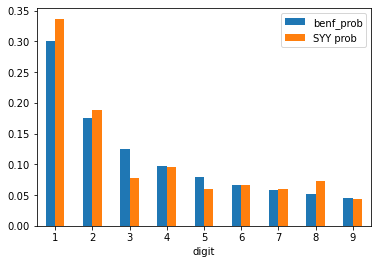

Goodness of fit for SYY is  20.758199855509602
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

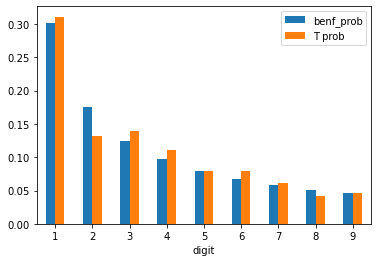

Goodness of fit for T is  10.589100410115364
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

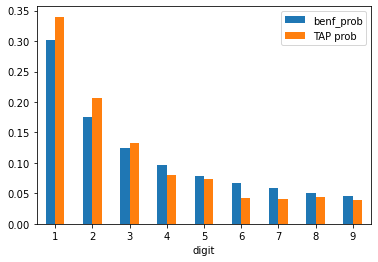

Goodness of fit for TAP is  17.381711405085063
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

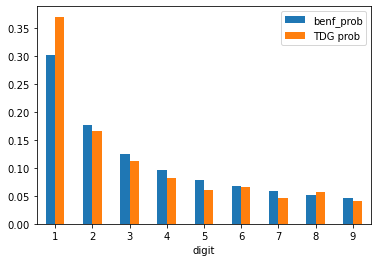

Goodness of fit for TDG is  15.895452695190338
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

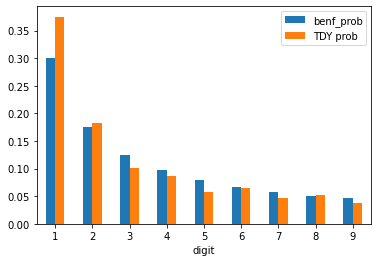

Goodness of fit for TDY is  19.74752241350498
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

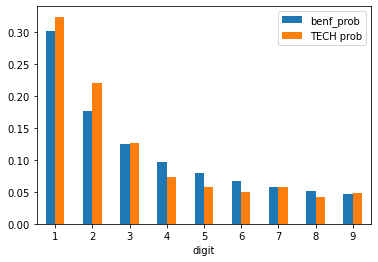

Goodness of fit for TECH is  17.008019691233834
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

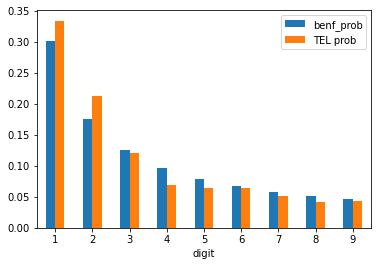

Goodness of fit for TEL is  14.362621887897449
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

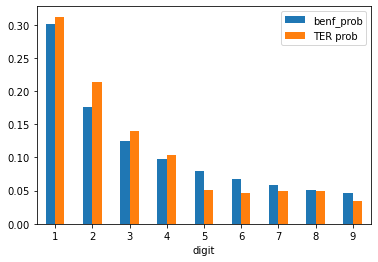

Goodness of fit for TER is  16.952939050582387
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

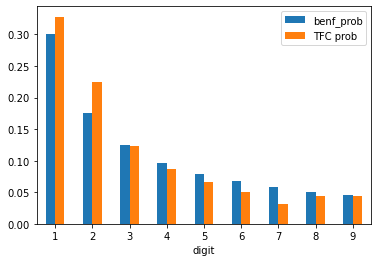

Goodness of fit for TFC is  20.676619772073405
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

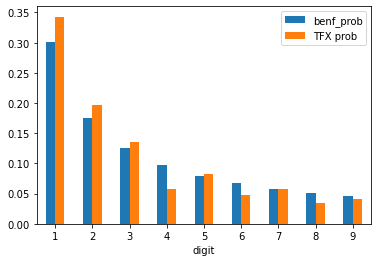

Goodness of fit for TFX is  20.243632650690348
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

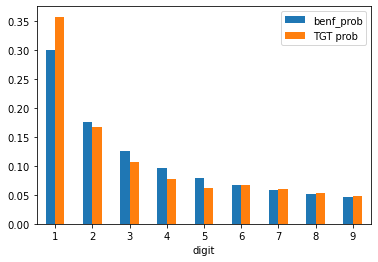

Goodness of fit for TGT is  12.138267406487994
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

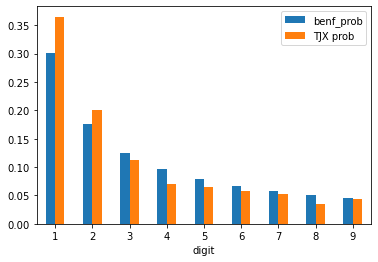

Goodness of fit for TJX is  19.957683642054285
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for TMO is  5.0925972224417695
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

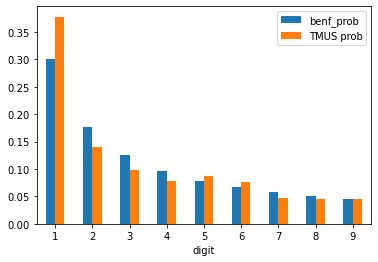

Goodness of fit for TMUS is  22.90226651906837
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

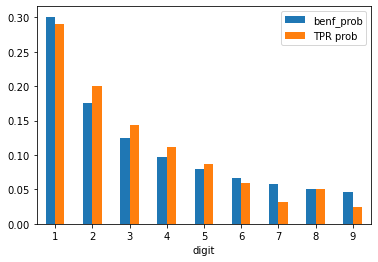

Goodness of fit for TPR is  17.989515015878883
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for TRMB is  12.810543621401571
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for TROW is  14.073308917055284
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for TRV is  7.580352954813939
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

Goodness of fit for TSCO is  19.919714915828866
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

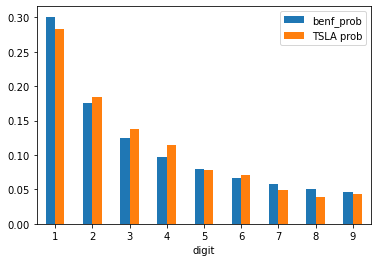

Goodness of fit for TSLA is  5.933569754146201
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

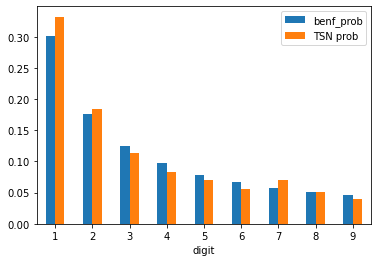

Goodness of fit for TSN is  7.571651258019223
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

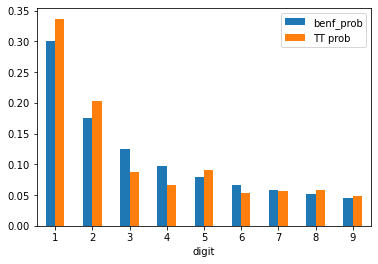

Goodness of fit for TT is  19.951952423833347
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

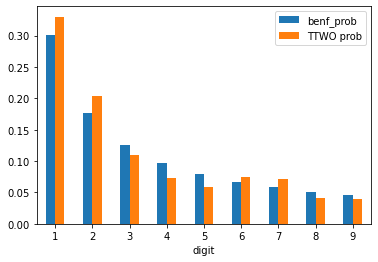

Goodness of fit for TTWO is  15.351919894159153
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

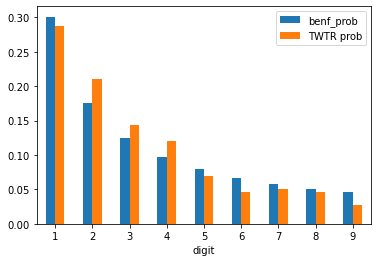

Goodness of fit for TWTR is  18.5872022260113
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

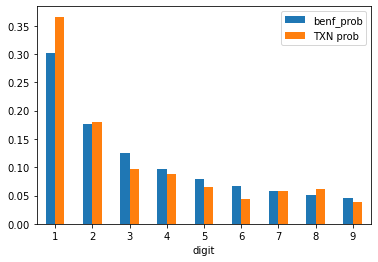

Goodness of fit for TXN is  19.54239424565935
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

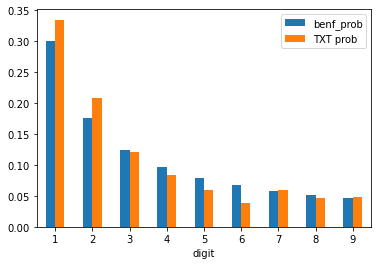

Goodness of fit for TXT is  16.298994593444206
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

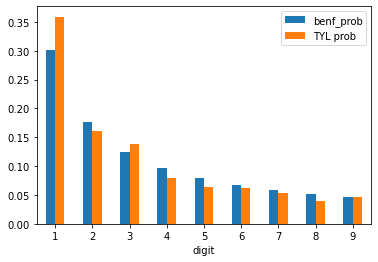

Goodness of fit for TYL is  13.325329999933688
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

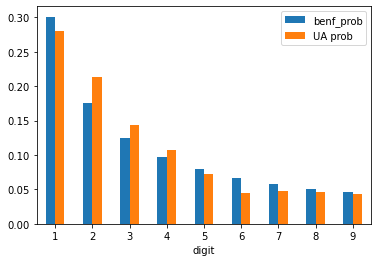

Goodness of fit for UA is  13.168562783243576
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

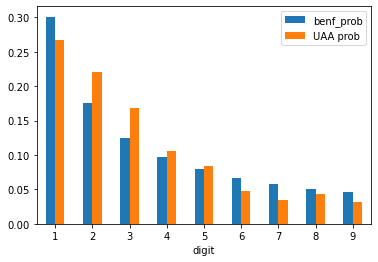

Goodness of fit for UAA is  29.382131821382142
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

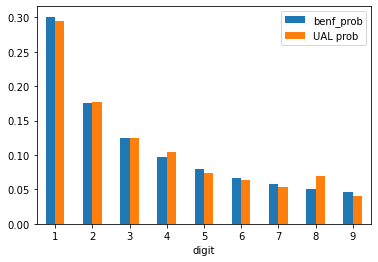

Goodness of fit for UAL is  4.799351772747828
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

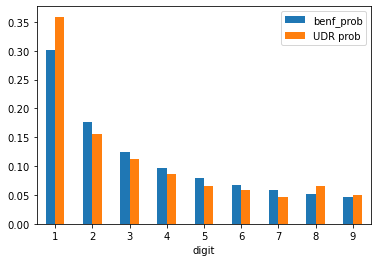

Goodness of fit for UDR is  14.861840086633853
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

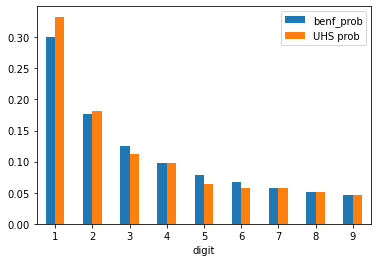

Goodness of fit for UHS is  4.891939088150421
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

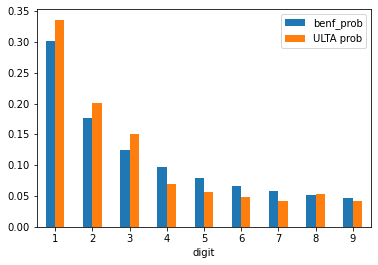

Goodness of fit for ULTA is  20.604640582704604
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

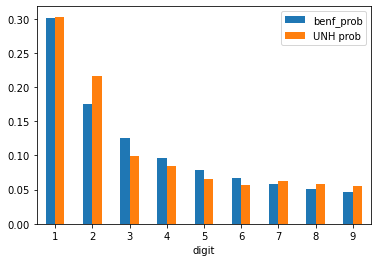

Goodness of fit for UNH is  12.933751739530557
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

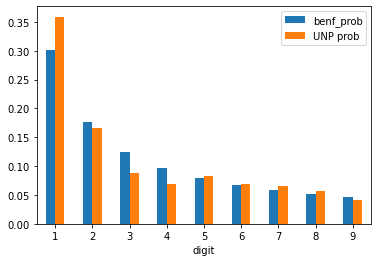

Goodness of fit for UNP is  18.46738265925756
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

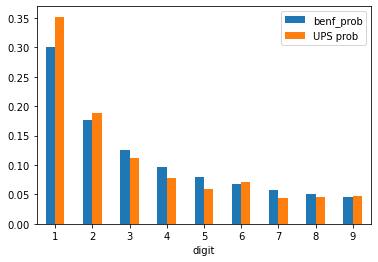

Goodness of fit for UPS is  13.26333066801281
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

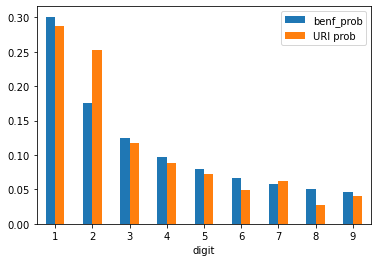

Goodness of fit for URI is  28.985989248415567
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

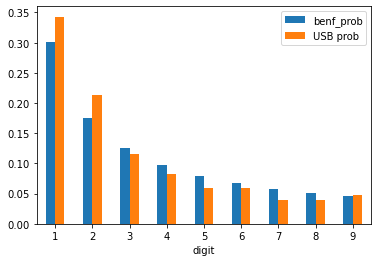

Goodness of fit for USB is  17.30497468301594
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

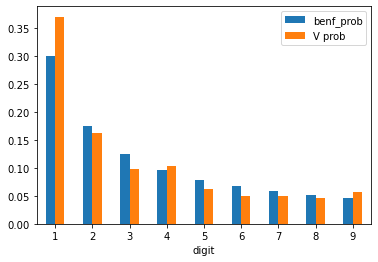

Goodness of fit for V is  20.25082949219029
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

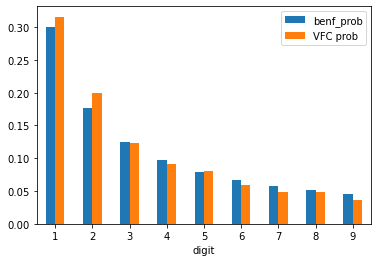

Goodness of fit for VFC is  4.982772923457856
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

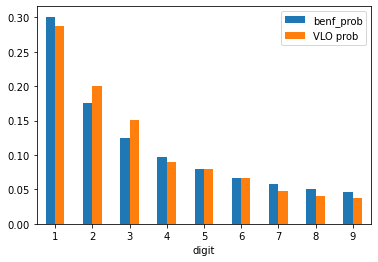

Goodness of fit for VLO is  8.604887226915148
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

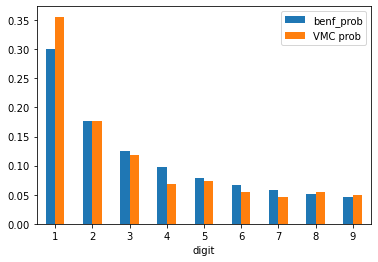

Goodness of fit for VMC is  13.653790914458332
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

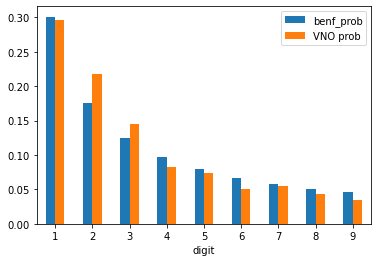

Goodness of fit for VNO is  13.605053188700591
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

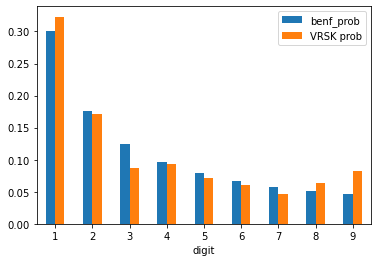

Goodness of fit for VRSK is  28.53536215194673
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

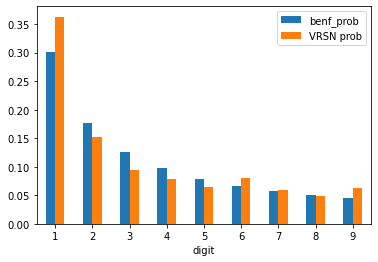

Goodness of fit for VRSN is  21.824710016355866
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

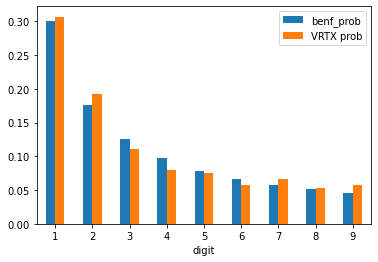

Goodness of fit for VRTX is  6.812391483260193
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

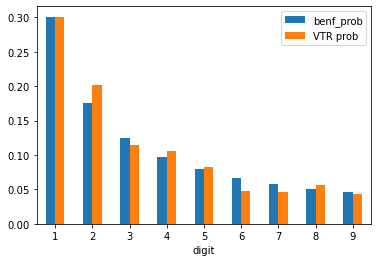

Goodness of fit for VTR is  8.23283615299913
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

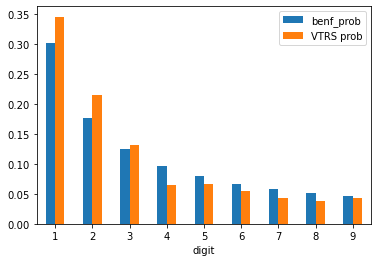

Goodness of fit for VTRS is  20.954307543177123
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

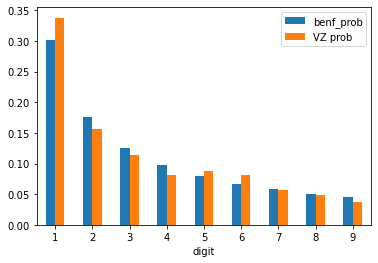

Goodness of fit for VZ is  8.937247451742252
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

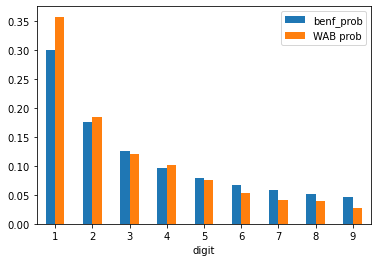

Goodness of fit for WAB is  16.68723297423181
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

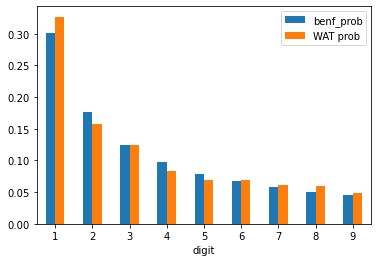

Goodness of fit for WAT is  4.910119046110264
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

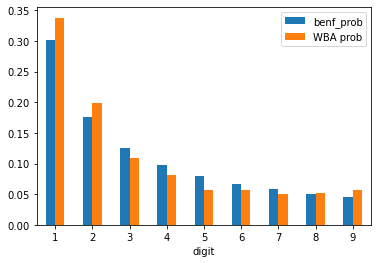

Goodness of fit for WBA is  12.815085431233484
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

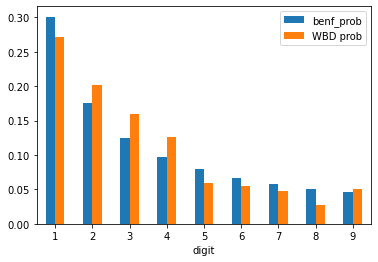

Goodness of fit for WBD is  25.752268206967013
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for WDC is  10.116725423102965
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

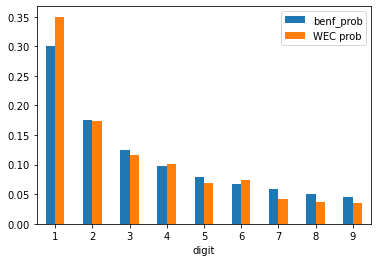

Goodness of fit for WEC is  12.012641772043574
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for WELL is  20.187183831070154
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for WFC is  17.29968783719965
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

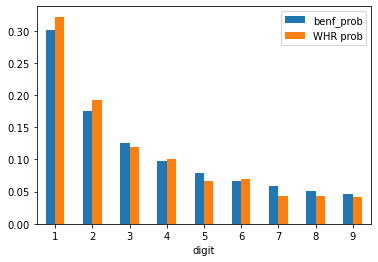

Goodness of fit for WHR is  5.6427144640194875
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

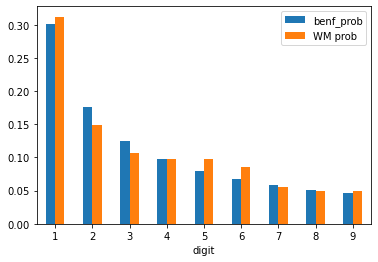

Goodness of fit for WM is  9.603481140280145
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

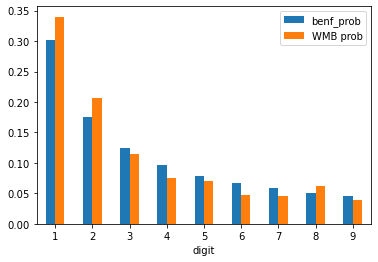

Goodness of fit for WMB is  16.644239977633603
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

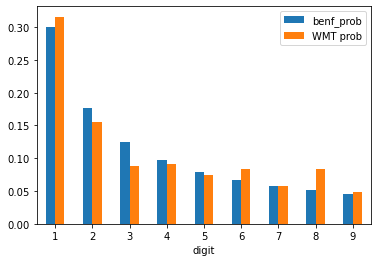

Goodness of fit for WMT is  21.910110673137204
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

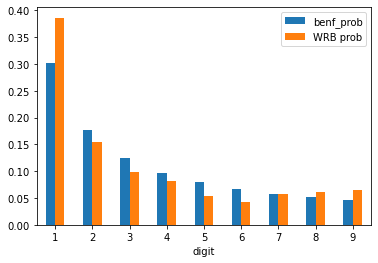

Goodness of fit for WRB is  34.56453263979933
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

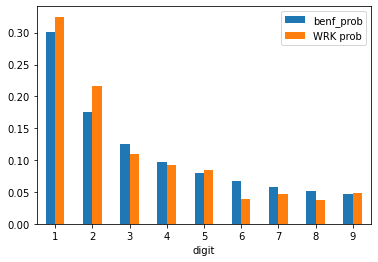

Goodness of fit for WRK is  17.806574731650976
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

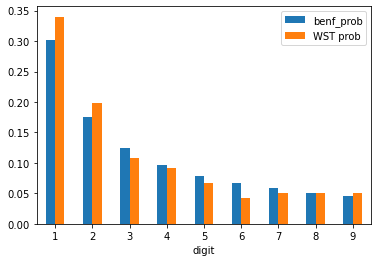

Goodness of fit for WST is  12.51849027822227
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

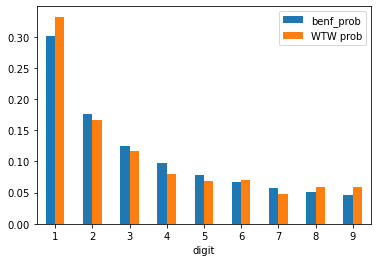

Goodness of fit for WTW is  8.401587158929374
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

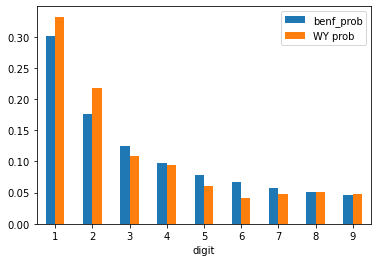

Goodness of fit for WY is  18.0895236819832
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373283

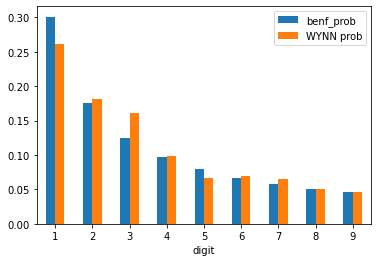

Goodness of fit for WYNN is  10.422867981962481
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

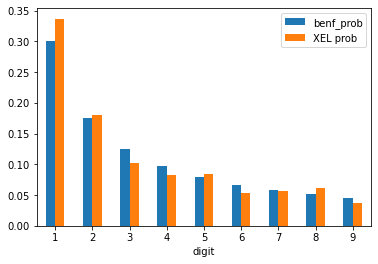

Goodness of fit for XEL is  9.986708026271938
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

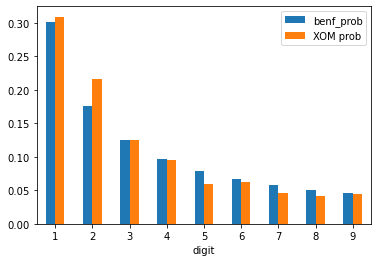

Goodness of fit for XOM is  10.245518726757775
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

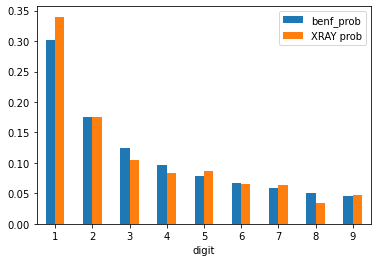

Goodness of fit for XRAY is  10.003155050495488
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

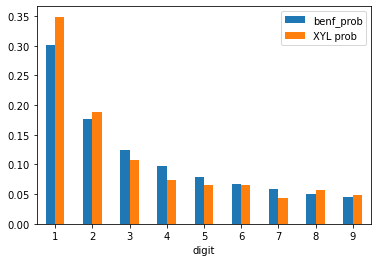

Goodness of fit for XYL is  12.703234450687797
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for YUM is  10.981988089100994
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.324373

Goodness of fit for ZBH is  8.241682702413044
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

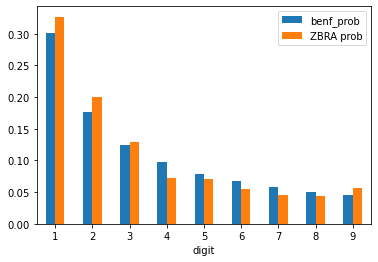

Goodness of fit for ZBRA is  11.711562343774425
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437

Goodness of fit for ZION is  19.350764027162
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.32437328

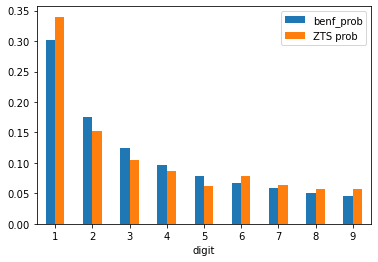

Goodness of fit for ZTS is  12.31158480639673
{'A': 6.782939858446429, 'AAL': 8.679521446221232, 'AAP': 18.763717259981412, 'AAPL': 19.590111773374698, 'ABBV': 17.49134714165514, 'ABC': 16.189259600524398, 'ABMD': 17.721136969993772, 'ABT': 12.270225537378655, 'ACN': 12.12264860013799, 'ADBE': 10.41718539947774, 'ADI': 9.26531878568213, 'ADM': 24.626897412925548, 'ADP': 26.46442867225178, 'ADSK': 8.007082836242871, 'AEE': 17.364419474558353, 'AEP': 8.669205191869949, 'AES': 2.9585508570530807, 'AFL': 16.869712391597695, 'AIG': 12.580346851907237, 'AIZ': 10.45346661847789, 'AJG': 13.622444768542229, 'AKAM': 6.211185184723109, 'ALB': 20.74836443588689, 'ALGN': 18.853685602903383, 'ALK': 15.659707170468598, 'ALL': 26.751711789750896, 'ALLE': 16.298019542593863, 'AMAT': 18.960523449179107, 'AMCR': 16.1390193975623, 'AMD': 19.989324080660257, 'AME': 8.03662401738921, 'AMGN': 18.09210074640786, 'AMP': 8.045926620118642, 'AMT': 13.860285896486326, 'AMZN': 7.718906095737118, 'ANET': 35.3243732

In [22]:
#create empty dict to store chi squared values
chi_squared = {}

for key, values in dic.items():
    fsd_list = []
    for value in values:
        fsd_list.append(int(str(value)[:1]))

    #check if all values from 1 to 9 appear in the list
    unique_values = set(fsd_list)
    print(str(key), unique_values)
    
    #there can be 0s in the list. This is because there are closing prices that havent changed from one day to another. we will drop the 0s from the list
    fsd_list = [x for x in fsd_list if x != 0]
    unique_values2 = set(fsd_list)
    print(str(key), unique_values2)

    #creating a dictionary with key = benford digits and value = frequency of that number
    ##freq = {} 
    digits = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    start_values = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    freq = {key:value for key, value in zip(digits, start_values)}
    for item in fsd_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
            
    #by default, the dict "freq" will be un-ordered. for easier use, we sort the dict by key
    freq_ord = collections.OrderedDict(sorted(freq.items()))
    print(freq_ord)
    
    
    #calculate benford probability of the keys (numbers 1 to 9)
    benf_prob = [round(np.log10(1 + 1/i), 3) for i in freq_ord.keys()]
    benf_prob
    
    
    #calculate probability of fsd for the ticker
    digit_prob = [round(i / sum(freq_ord.values()),3) for i in freq_ord.values() ]
    digit_prob
    
    
    #create dataframe from dict and benf_prob and digit_prob
    df = pd.DataFrame(list(freq_ord.items()),columns = ['digit','count']) 
    name = str(key)
    df['benf_prob'] = benf_prob
    df['digit_prob'] = digit_prob
    df['count_expected'] = df['count'].sum() * df['benf_prob']
    df = df.rename(columns={'digit_prob':name + ' prob'})
    print(df)
    
    #create barplot
    df.plot.bar(x= 'digit', y=['benf_prob', df.columns[3]], rot = 0, legend = True)
    plt.show()
    df = df.rename(columns={name + ' prob':'digit_prob'})
    
    #calculate sum of chi_squared values
    chi_sq = np.sum(((df['count_expected'] - df['count']) ** 2)/df['count_expected'])
    print('Goodness of fit for ' + key  + ' is ', chi_sq)
    print(chi_squared)
    chi_squared.update({key: chi_sq})
    

    

In [23]:
#create a dataframe from the dictionary with the chi square results
df_chisq = pd.DataFrame(list(chi_squared.items()),columns = ['Ticker','Chi Sq'])
df_chisq

Ticker     Chi Sq
0        A   6.782940
1      AAL   8.679521
2      AAP  18.763717
3     AAPL  19.590112
4     ABBV  17.491347
..     ...        ...
493    YUM  10.981988
494    ZBH   8.241683
495   ZBRA  11.711562
496   ZION  19.350764
497    ZTS  12.311585

[498 rows x 2 columns]

In [24]:
#descriptie statistics of all chi square values
df_chisq.describe()

Chi Sq
count  498.000000
mean    15.647812
std      6.477705
min      2.184803
25%     10.991523
50%     14.957957
75%     19.300793
max     47.301972

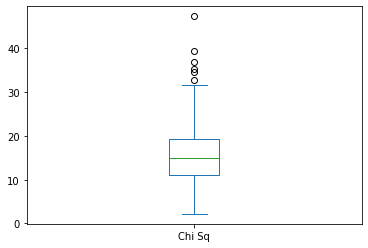

In [25]:
#plottting the values
df_chisq.plot(x ='Ticker', y='Chi Sq', kind = 'box')
plt.show()

In [26]:
#create a dataframe with all chi-square-testvalues that are below the critical value of 15.507 (8 df, alpha = 0.05)
dfbenf = df_chisq[df_chisq['Chi Sq'] < 15.507]
dfbenf

Ticker     Chi Sq
0        A   6.782940
1      AAL   8.679521
7      ABT  12.270226
8      ACN  12.122649
9     ADBE  10.417185
..     ...        ...
492    XYL  12.703234
493    YUM  10.981988
494    ZBH   8.241683
495   ZBRA  11.711562
497    ZTS  12.311585

[260 rows x 2 columns]

## 3.3. Performance comparison

In [27]:
#create list from Tickers that are benford-distributed. Will be used later.
benf_ticker_list = dfbenf['Ticker'].tolist()
benf_ticker_list

['A',
 'AAL',
 'ABT',
 'ACN',
 'ADBE',
 'ADI',
 'ADSK',
 'AEP',
 'AES',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'AME',
 'AMP',
 'AMT',
 'AMZN',
 'AON',
 'APA',
 'APD',
 'ARE',
 'ATO',
 'ATVI',
 'AWK',
 'AZO',
 'BA',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BKNG',
 'BKR',
 'BLK',
 'BRO',
 'BSX',
 'BWA',
 'BXP',
 'CAH',
 'CB',
 'CBRE',
 'CDNS',
 'CDW',
 'CERN',
 'CHRW',
 'CINF',
 'CL',
 'CLX',
 'CMI',
 'CNP',
 'CRM',
 'CSCO',
 'CTSH',
 'CTVA',
 'CTXS',
 'DE',
 'DFS',
 'DG',
 'DGX',
 'DHR',
 'DIS',
 'DISH',
 'DOV',
 'DPZ',
 'DRI',
 'DTE',
 'DVA',
 'DVN',
 'DXC',
 'EBAY',
 'ED',
 'EIX',
 'EL',
 'EMR',
 'EOG',
 'EQR',
 'ETN',
 'ETR',
 'EXC',
 'EXPE',
 'F',
 'FANG',
 'FDS',
 'FDX',
 'FE',
 'FFIV',
 'FIS',
 'FISV',
 'FITB',
 'FLT',
 'FOX',
 'FOXA',
 'FRT',
 'FTV',
 'GD',
 'GE',
 'GIS',
 'GL',
 'GM',
 'GNRC',
 'GOOG',
 'GOOGL',
 'GPC',
 'HAL',
 'HBAN',
 'HCA',
 'HD',
 'HIG',
 'HII',
 'HLT',
 'HOLX',
 'HPQ',
 'HSIC',
 'HWM',
 'IBM',
 'ICE',
 'IDXX',
 'IEX',
 'IFF',
 'INCY',
 'IP',
 'IPGP',

In [28]:
#create new df from dfclean, where all tickers are dropped that are not benford-distributed
dfbenford = dfclean.drop(dfclean.columns.difference(benf_ticker_list), axis = 1)

#calculate performance for this new dataset
#first calculate pct_change, + 1 for easier cumulative return calculation
dfbenford = dfbenford.pct_change() + 1

#calculate cumulative return for every ticker in df, append to list, calculate average return
perf_list_benford = []
for col in dfbenford.columns:
    ret = (100 * dfbenford[col].cumprod()[-1] - 100)/100
    perf_list_benford.append(ret)
    
    
benford_return = round(100 * sum(perf_list_benford)/len(perf_list_benford),3)
benford_return 

47.158

In [38]:
(dfbenford.values.cumprod()).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [30]:
#create new df from dfclean, where all tickers that are NOT benford distributed are KEPT
df_not_benford = dfclean.drop(benf_ticker_list, axis = 1)

#calculate performance for this new dataset
#first calculate pct_change, + 1 for easier cumulative return calculation
df_not_benford = df_not_benford.pct_change() + 1

#calculate cumulative return for every ticker in df, append to list, calculate average return
perf_list_not_benford = []
for col in df_not_benford.columns:
    ret = (100 * df_not_benford[col].cumprod()[-1] - 100)/100
    perf_list_not_benford.append(ret)
    
    
not_benford_return = round(100 * sum(perf_list_not_benford)/len(perf_list_not_benford),3)
not_benford_return 

51.24

In [31]:
#calculate return overall from dfclean for all tickers to compare to benford and non-benford distributed tickers
dfreturn = data_pct + 1
dfreturn.head()

perf_list = []
for col in dfreturn.columns:
    ret = (100 * dfreturn[col].cumprod()[-1] - 100)/100
    perf_list.append(ret)
    
overall_return = round(100 * sum(perf_list)/len(perf_list),3)
overall_return

49.109

In [32]:
print('Performance overall\t\t ' + str(overall_return))
print('Performance non-benford tickers\t ' + str(not_benford_return))
print('Performance benford tickers\t ' + str(benford_return))

Performance overall		 49.109
Performance non-benford tickers	 51.24
Performance benford tickers	 47.158
